In [16]:
pip install numpy pandas matplotlib seaborn yfinance scipy scikit-learn statsmodels


Note: you may need to restart the kernel to use updated packages.


In [17]:
pip install riskfolio-lib


Note: you may need to restart the kernel to use updated packages.


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime as dt
from datetime import datetime
from matplotlib import style
import matplotlib.dates as mdates

import scipy.stats as stats
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error
from math import sqrt
import itertools
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import riskfolio as rp

# Set visual styles for plotting
sns.set(style="whitegrid")
style.use('ggplot')

# Configure warnings to ignore them
warnings.filterwarnings("ignore")


# Progetto Business Intelligence per i Servizi Finanziari 2023/2024

---


Richard Rabi, n° matricola 869353


In [19]:
start_date = '2014-05-31'
end_date = '2024-05-31'

In [20]:
tickers = ["AMZN", "MCD", "PG", "WMT", "AAPL", "NVDA"]

In [21]:
adjusted_close_df  = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  6 of 6 completed


In [22]:
adjusted_close_df = adjusted_close_df.round(2)
adjusted_close_df.head()

Ticker       AAPL   AMZN    MCD  NVDA     PG    WMT
Date                                               
2014-06-02  19.89  15.44  78.68  0.45  60.44  20.80
2014-06-03  20.17  15.36  78.23  0.45  60.12  20.79
2014-06-04  20.40  15.34  78.99  0.45  60.06  20.90
2014-06-05  20.48  16.18  79.00  0.45  60.25  20.95
2014-06-06  20.42  16.48  78.62  0.45  60.19  20.92

#2. Statistiche descrittive

a. Calcolare il rendimento cumulato e composto annuo di ciascun titolo nel periodo;

In [23]:
# Calcolo dei ritorni giornalieri
daily_returns = adjusted_close_df.pct_change()

# Calcolo dei ritorni cumulativi
cumulative_returns = (1 + daily_returns).cumprod()

# Estrazione dell'ultimo valore dei ritorni cumulativi, che rappresenta il rendimento cumulativo complessivo
cumulative_returns_complessivo = cumulative_returns.iloc[-1]

# Arrotondamento per visualizzazione chiara
cumulative_returns_complessivo = cumulative_returns_complessivo.round(4)  # Arrotondare a 4 cifre decimali per precisione

# Convertire i rendimenti cumulativi in percentuali
cumulative_returns_percentuali = (cumulative_returns_complessivo - 1) * 100

cumulative_returns_complessivo.round(2)

Ticker
AAPL      9.62
AMZN     11.61
MCD       3.18
NVDA    245.53
PG        2.69
WMT       3.12
Name: 2024-05-30 00:00:00, dtype: float64

In [24]:
print(cumulative_returns_percentuali.map('{:.2f}%'.format))

Ticker
AAPL      861.74%
AMZN     1061.40%
MCD       218.30%
NVDA    24453.33%
PG        168.99%
WMT       211.97%
Name: 2024-05-30 00:00:00, dtype: object


In [25]:
# Calcolo della durata dell'investimento in giorni
delta = datetime.strptime(end_date, '%Y-%m-%d') - datetime.strptime(start_date, '%Y-%m-%d')
t = delta.days
years = t / 365.25

# Preparazione del DataFrame per contenere il CAGR
cagr_df = pd.DataFrame(index=tickers)

# Calcolo del CAGR per ogni ticker
for ticker in tickers:
    final_value = adjusted_close_df[ticker].iloc[-1]
    initial_value = adjusted_close_df[ticker].iloc[0]
    cagr = (final_value / initial_value) ** (1 / years) - 1
    #cagr_df.loc[ticker, 'Initial Value'] = initial_value
    #cagr_df.loc[ticker, 'Final Value'] = final_value
    cagr_df.loc[ticker, 'CAGR'] = cagr.round(2)

#Arrotondo per 2° cifra decimale
cagr_df.round(2)
# Stampa del DataFrame con i CAGR per ciascun ticker
cagr_df

CAGR
AMZN  0.28
MCD   0.12
PG    0.10
WMT   0.12
AAPL  0.25
NVDA  0.73

b. Calcolare i rendimenti semplici e logaritmici e visualizzarli in un grafico

In [26]:
# creo dataframe dove salverò i ritorni
returns_df = pd.DataFrame(index=adjusted_close_df.index)

for ticker in tickers:

  # Rendimento Semplice lordo - Non rilevante per la mia analisi
  returns_df[f'{ticker} RS_Lordo'] = adjusted_close_df[ticker] / adjusted_close_df[ticker].shift(1)

  # Rendimenti semplici netto
  returns_df[f'{ticker} RS_Netto'] = adjusted_close_df[ticker].pct_change(1)

  # Rendimenti logaritmici
  returns_df[f'{ticker} RL'] = np.log(adjusted_close_df[ticker] / adjusted_close_df[ticker].shift(1))
  returns_df.dropna(inplace = True)

In [27]:
log_returns_df = returns_df[['AMZN RL','MCD RL','PG RL','WMT RL','AAPL RL','NVDA RL']] # DATAFRAME FATTO SOLO PER LA VISUALIZZIONE
log_returns_df.head()

AMZN RL    MCD RL     PG RL    WMT RL   AAPL RL  NVDA RL
Date                                                                 
2014-06-03 -0.005195 -0.005736 -0.005309 -0.000481  0.013979      0.0
2014-06-04 -0.001303  0.009668 -0.000999  0.005277  0.011339      0.0
2014-06-05  0.053312  0.000127  0.003159  0.002389  0.003914      0.0
2014-06-06  0.018372 -0.004822 -0.000996 -0.001433 -0.002934      0.0
2014-06-09 -0.006086 -0.005612  0.000830 -0.002393  0.016031      0.0

In [28]:
# Calcolo della media dei rendimenti per ogni ticker
mean_returns_df = pd.DataFrame(index=tickers)

for ticker in tickers:
    mean_returns_df.loc[ticker, 'Mean RS_Netto'] = returns_df[f'{ticker} RS_Netto'].mean() #Rendimento netto medio giornaliero
    mean_returns_df.loc[ticker, 'Mean RL'] = returns_df[f'{ticker} RL'].mean() #Rendimento logaritmico medio giornaliero

# Stampa del DataFrame con le medie dei rendimenti
mean_returns_df.round(4)

Mean RS_Netto  Mean RL
AMZN         0.0012   0.0010
MCD          0.0005   0.0005
PG           0.0005   0.0004
WMT          0.0005   0.0005
AAPL         0.0011   0.0009
NVDA         0.0026   0.0022

# Questo va bene, da farlo per ogni ticker

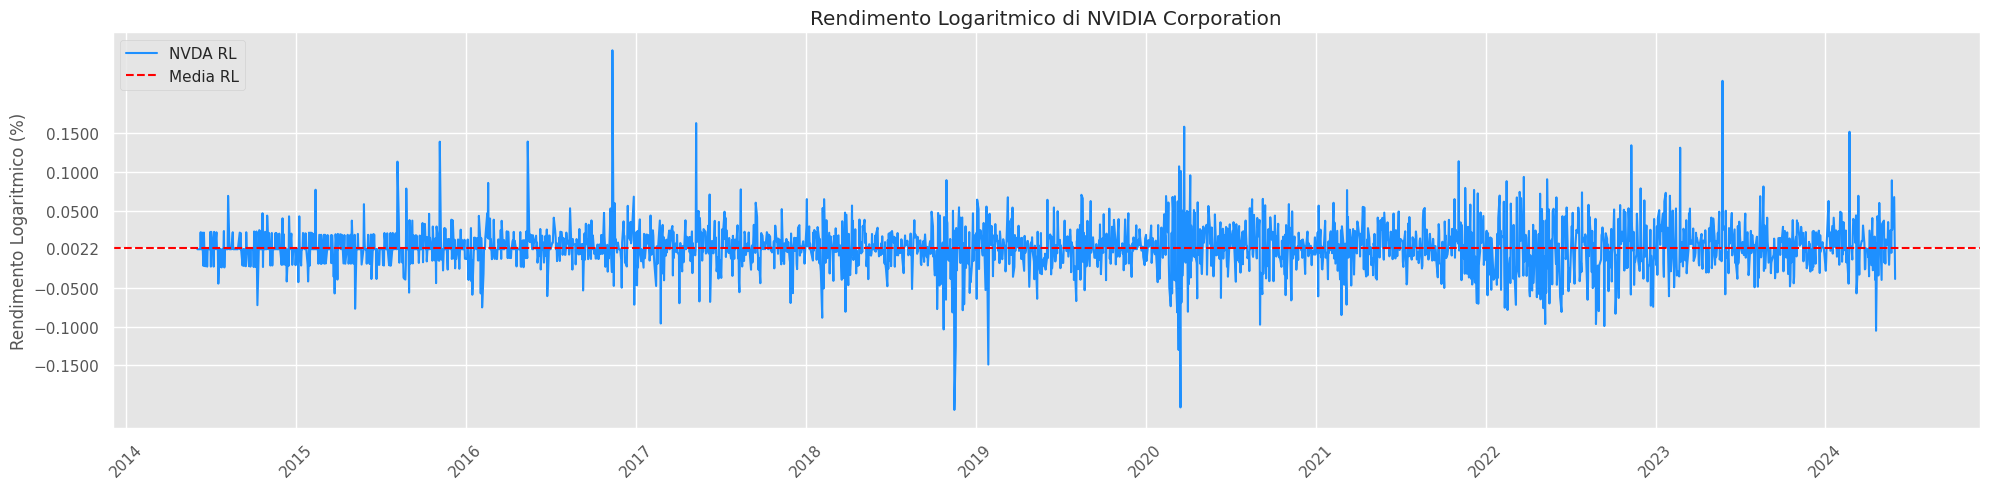

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Seleziona i rendimenti logaritmici di Amazon
label_plot_log = "NVDA RL"
nome_azienda = "NVIDIA Corporation"
valore_mean_log = 0.0022

returns_log = returns_df[label_plot_log]

# Crea una figura e un asse del grafico
fig, ax = plt.subplots(figsize=(20, 5))

# Grafico dei rendimenti logaritmici
ax.plot(returns_log.index, returns_log, color='dodgerblue', label=label_plot_log)  # Changed to blue to match the figure
ax.set_title(f'Rendimento Logaritmico di {nome_azienda}')
ax.set_ylabel('Rendimento Logaritmico (%)')
ax.axhline(valore_mean_log, color='red', linestyle='dashed', label='Media RL')  # Use 'lightblue' for better visibility
ax.set_yticks([-0.15, -0.10, -0.05, 0.05, 0.10, 0.15, valore_mean_log])
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [30]:
# Titoli per i grafici
return_types = ['RS_Netto', 'RL']

d. Presentare i rendimenti con istogrammi e confrontare la dispersione dei rendimenti dei diversi titoli

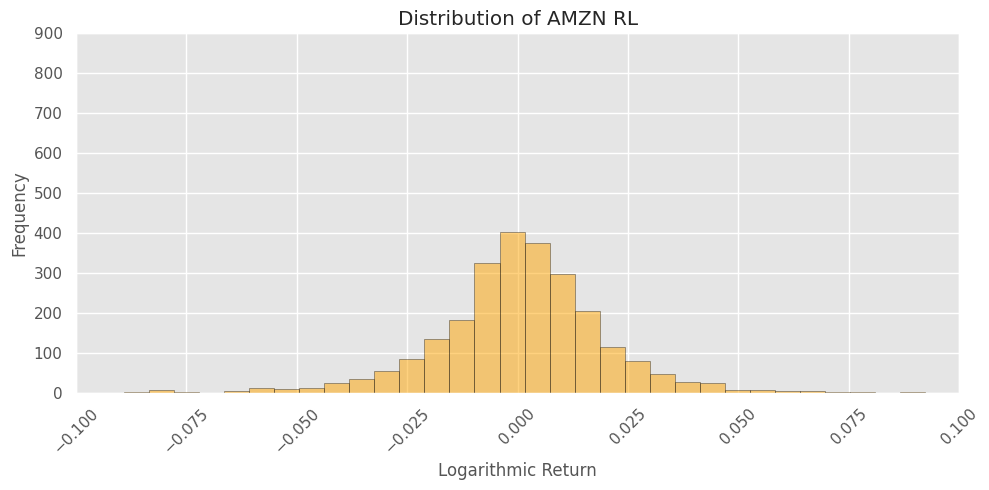

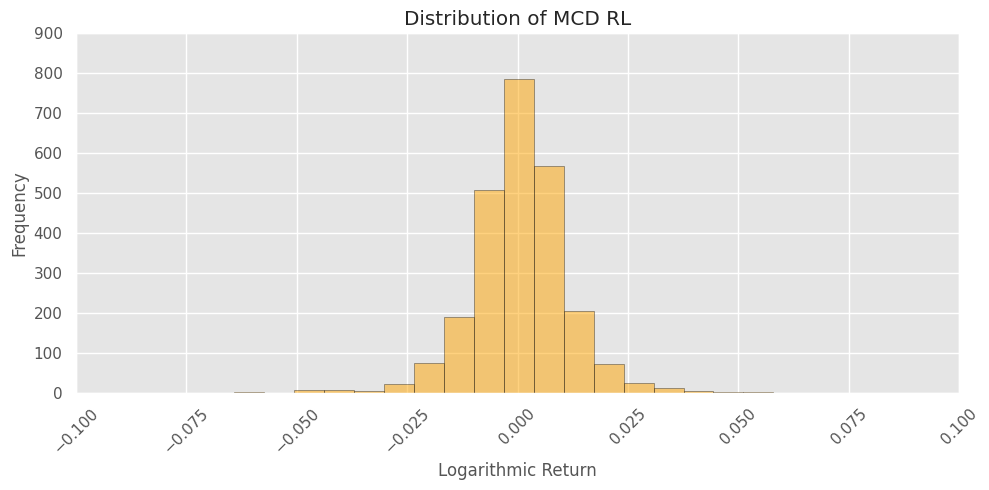

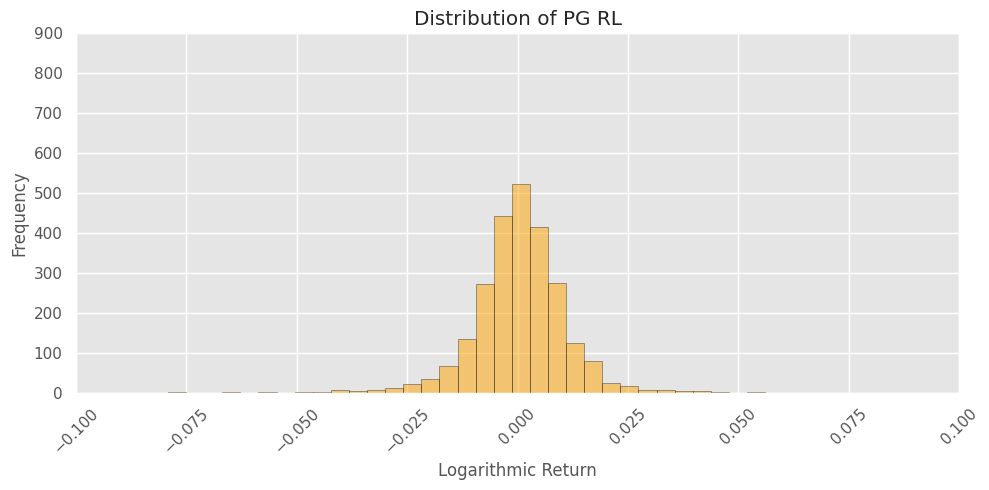

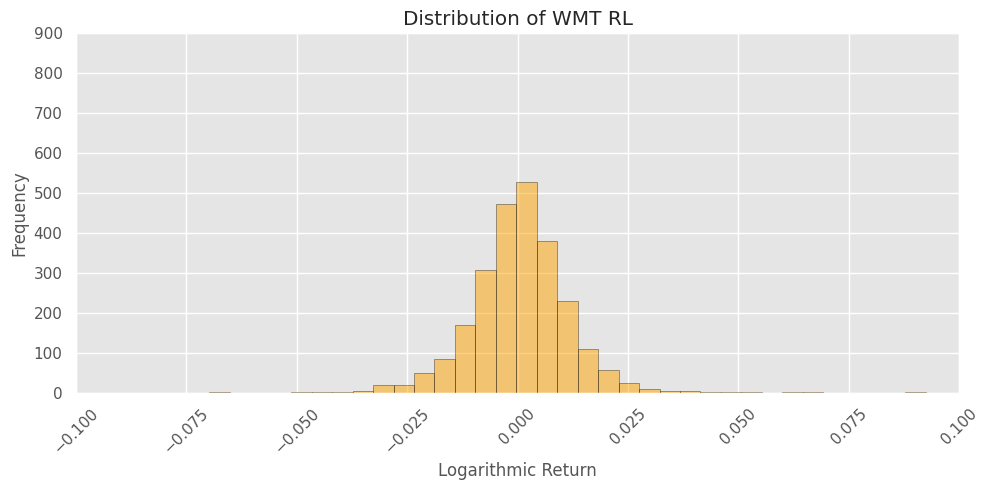

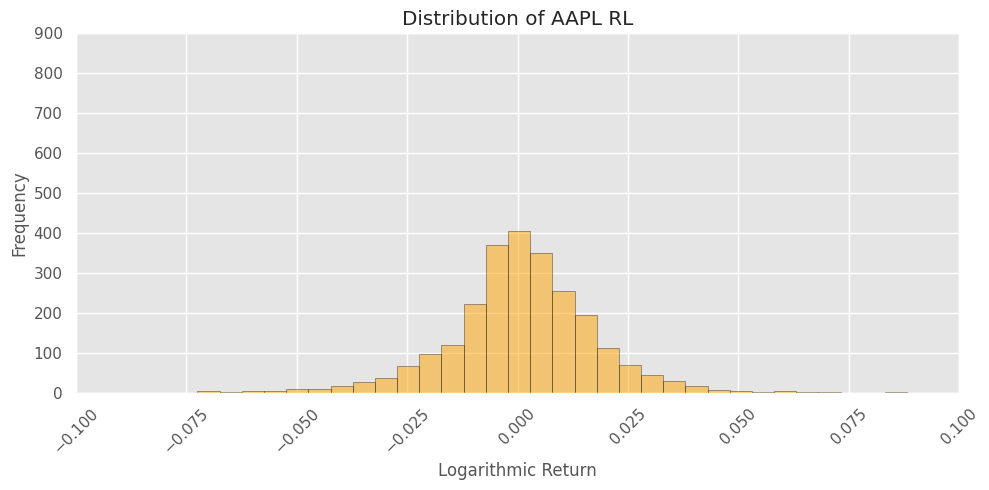

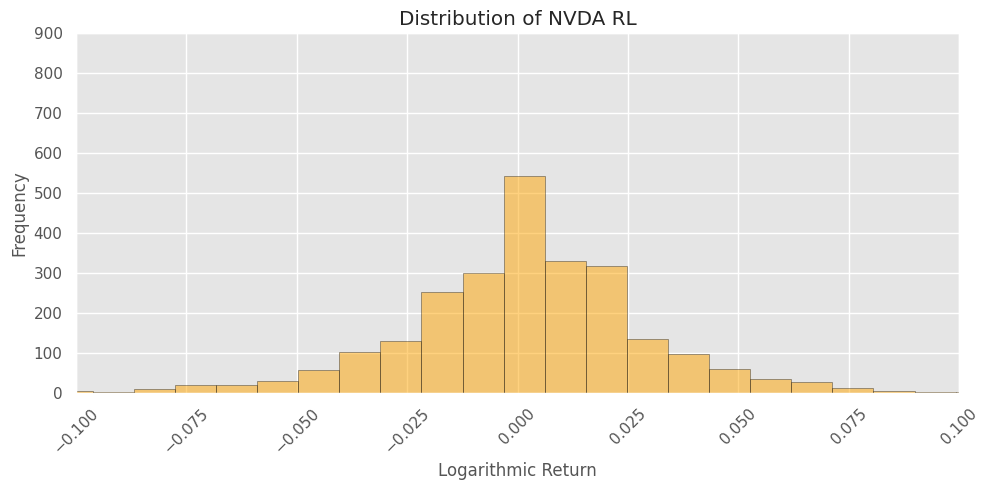

In [31]:
return_type = 'RL'  # Focus only on logarithmic returns
bins = 50  # Number of intervals for histograms

# Loop through each ticker to create a separate plot
for ticker in tickers:
    plt.figure(figsize=(10, 5))
    data_to_plot = returns_df[f'{ticker} {return_type}'].dropna()

    plt.hist(data_to_plot, bins=bins, alpha=0.5, color='orange', edgecolor='black', label=f'{ticker} {return_type}')
    plt.title(f'Distribution of {ticker} {return_type}')
    plt.xlabel('Logarithmic Return')
    plt.ylabel('Frequency')
    plt.xlim(-0.10, 0.10)
    plt.ylim(0, 900)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

e. Creare grafici diagnostici a 3 sezioni (istogramma e kernel density, boxplot, qq-plot) per ciascuna serie di rendimenti e commentare
(i rendimenti sono distribuiti normalmente?
Ci sono outliers?)

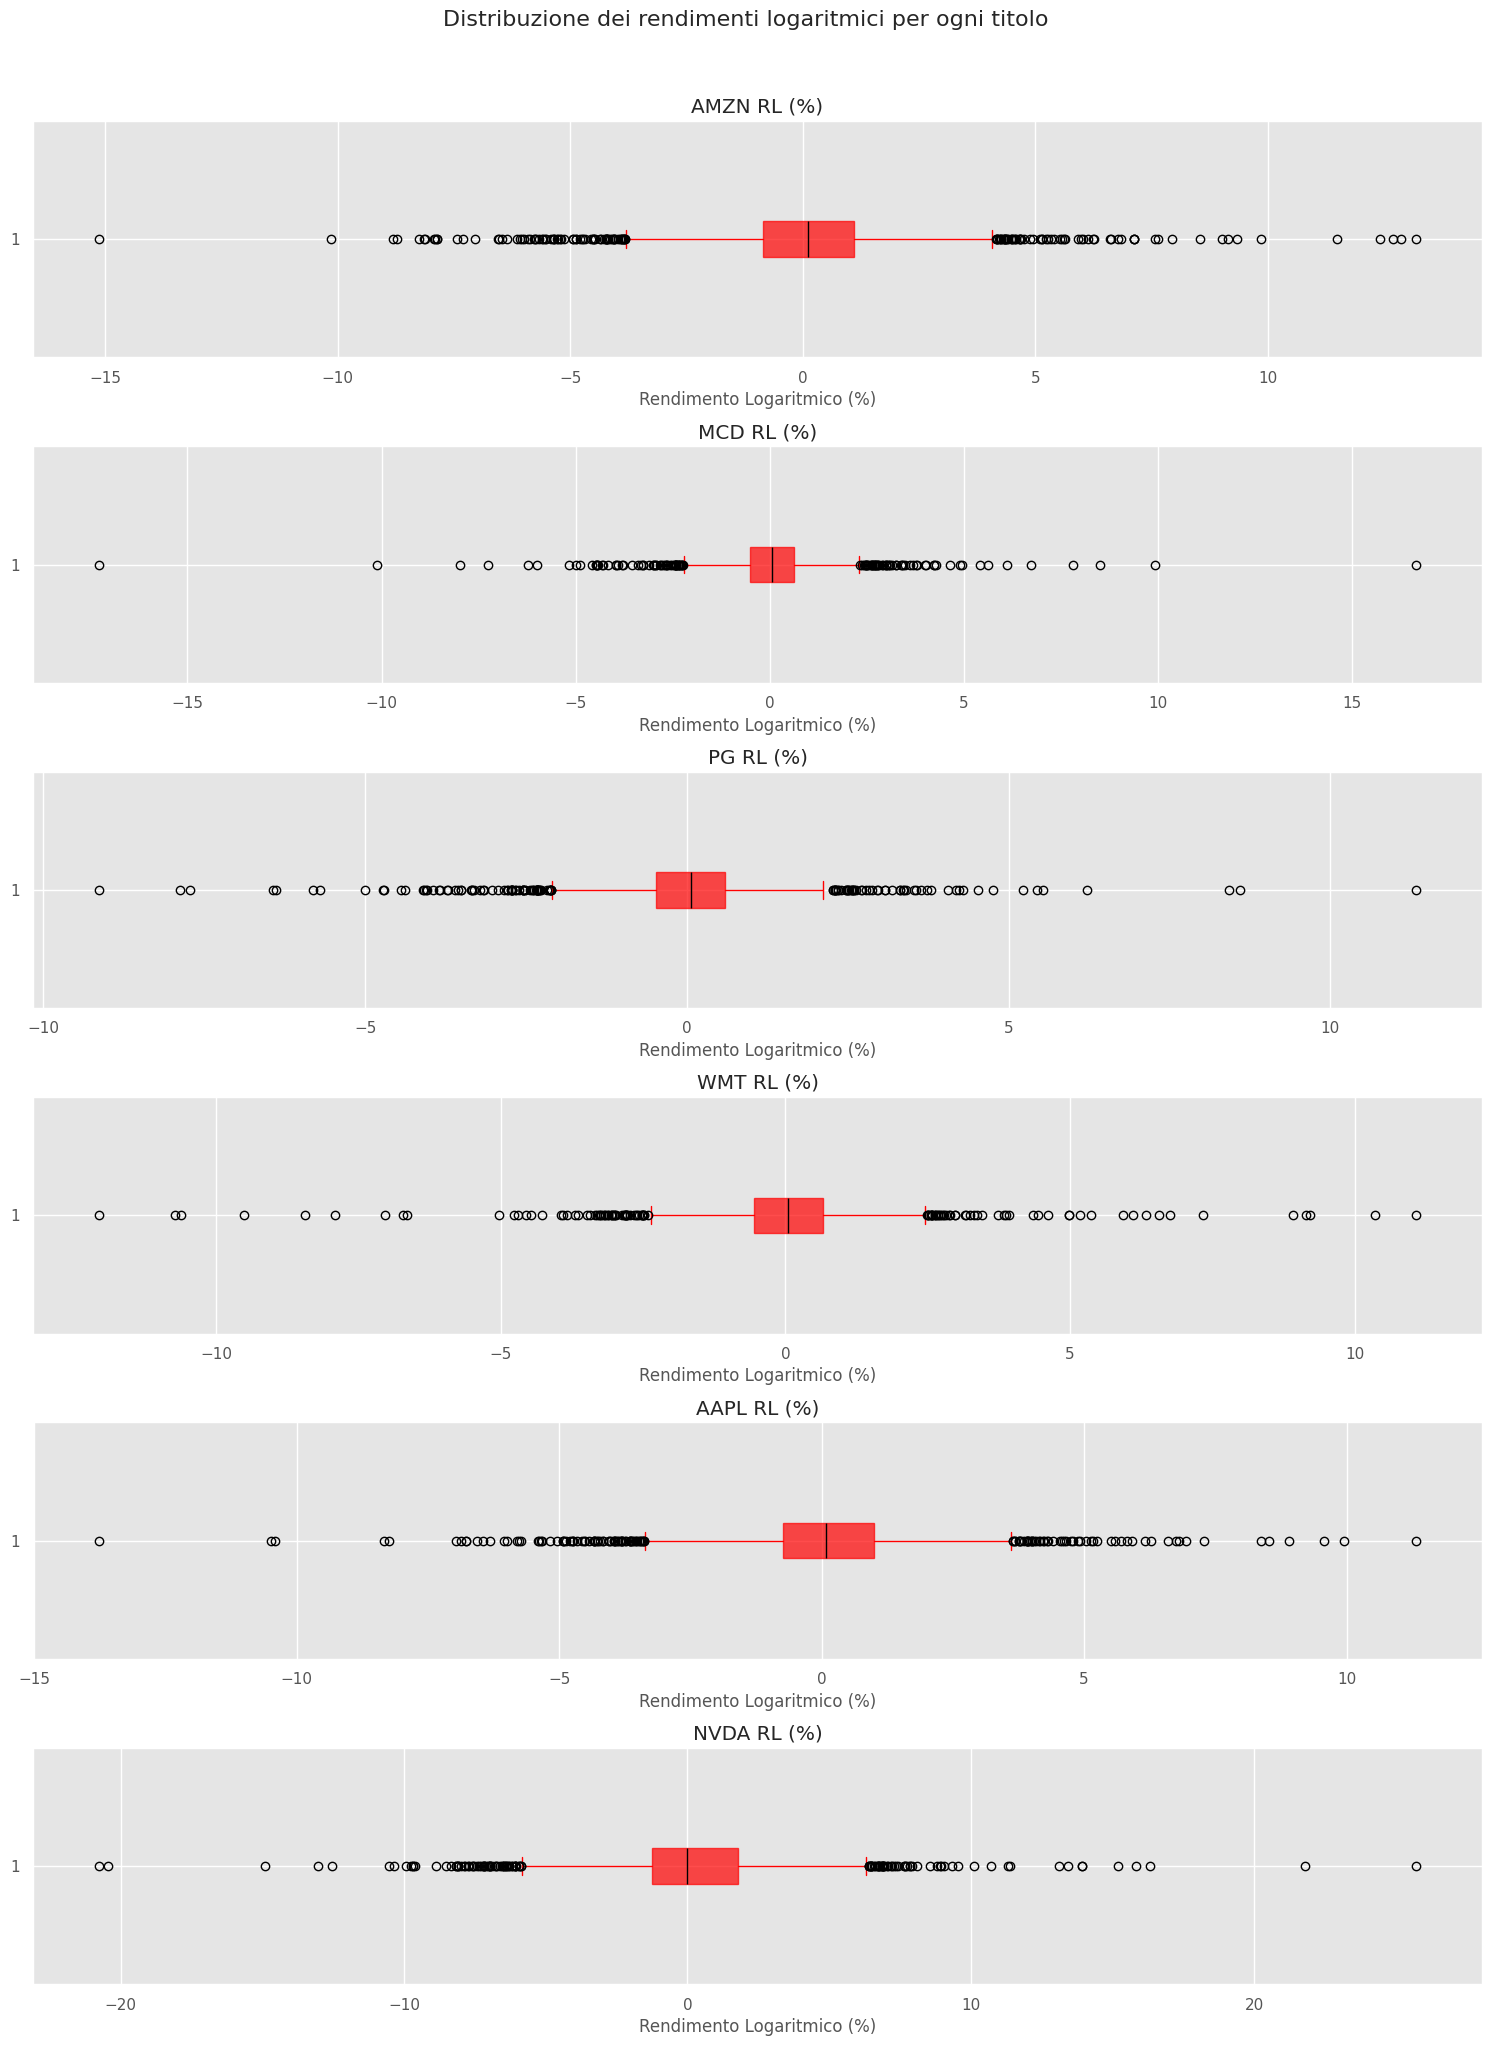

In [32]:
# Configurazione principale della figura
fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(15, 20))  # Una colonna per i rendimenti logaritmici
fig.suptitle('Distribuzione dei rendimenti logaritmici per ogni titolo', fontsize=16, y=1.02)

for i, ticker in enumerate(tickers):
    # Plotta solo il rendimento logaritmico in orizzontale
    axes[i].boxplot(returns_df[f'{ticker} RL'].dropna() * 100, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='red', color='red', alpha=0.7),
                    whiskerprops=dict(color='red'),
                    capprops=dict(color='red'),
                    medianprops=dict(color='black'))
    axes[i].set_title(f'{ticker} RL (%)')
    axes[i].set_xlabel('Rendimento Logaritmico (%)')
    axes[i].grid(True)

plt.tight_layout(pad=1.0)
plt.show()

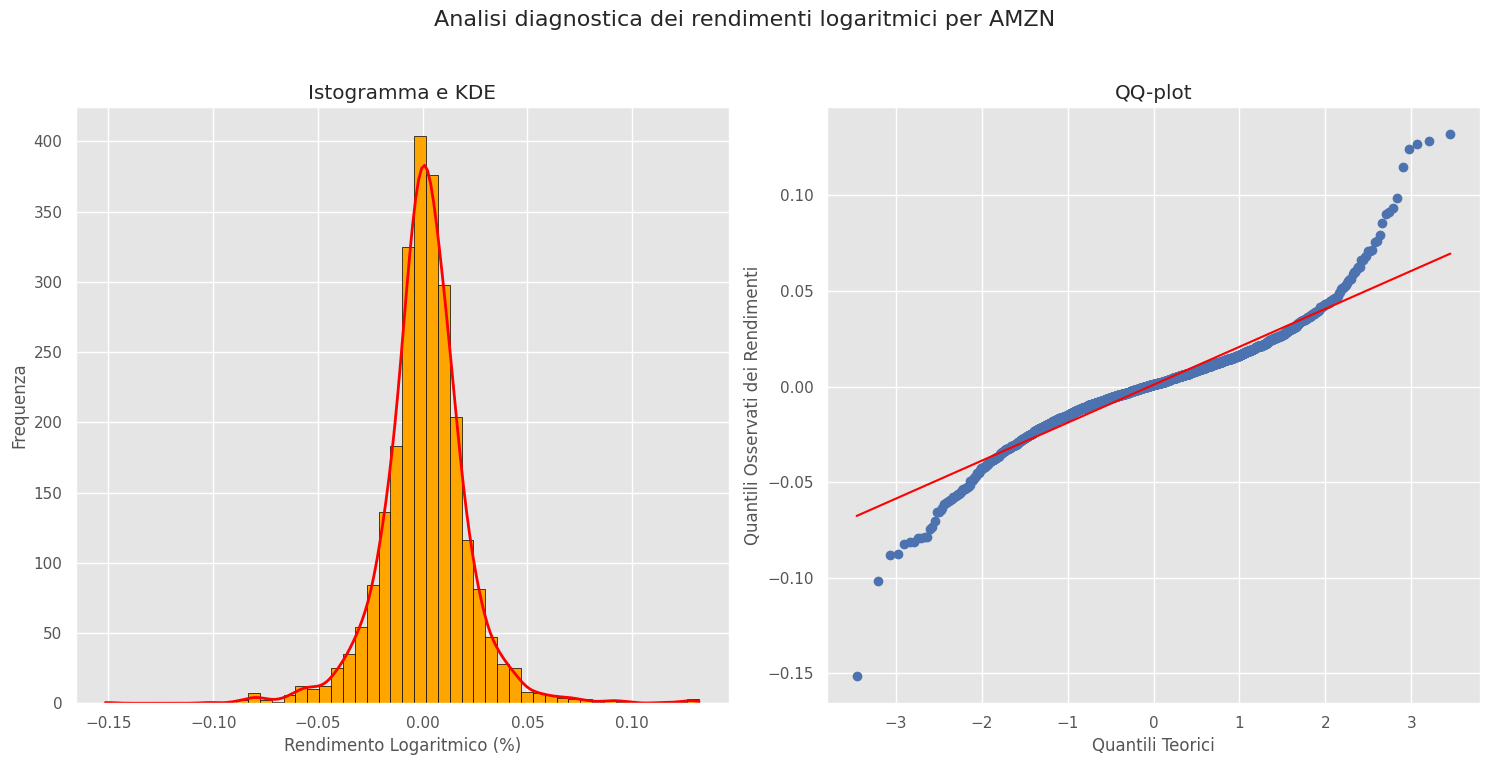

Analisi per AMZN:
I dati sono relativamente simmetrici.
I dati hanno una curtosi elevata, indicando la presenza di outlier.


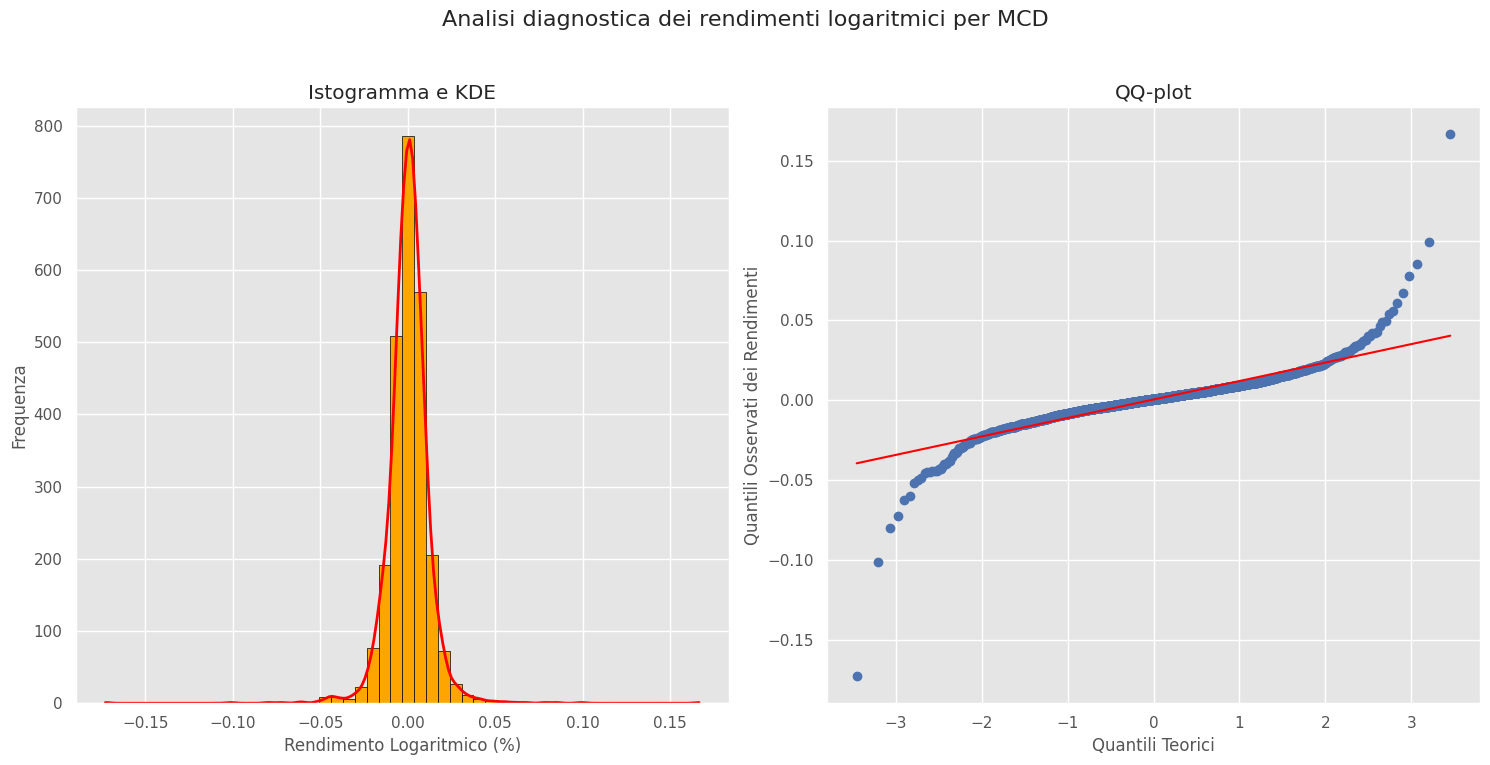

Analisi per MCD:
I dati sono relativamente simmetrici.
I dati hanno una curtosi elevata, indicando la presenza di outlier.


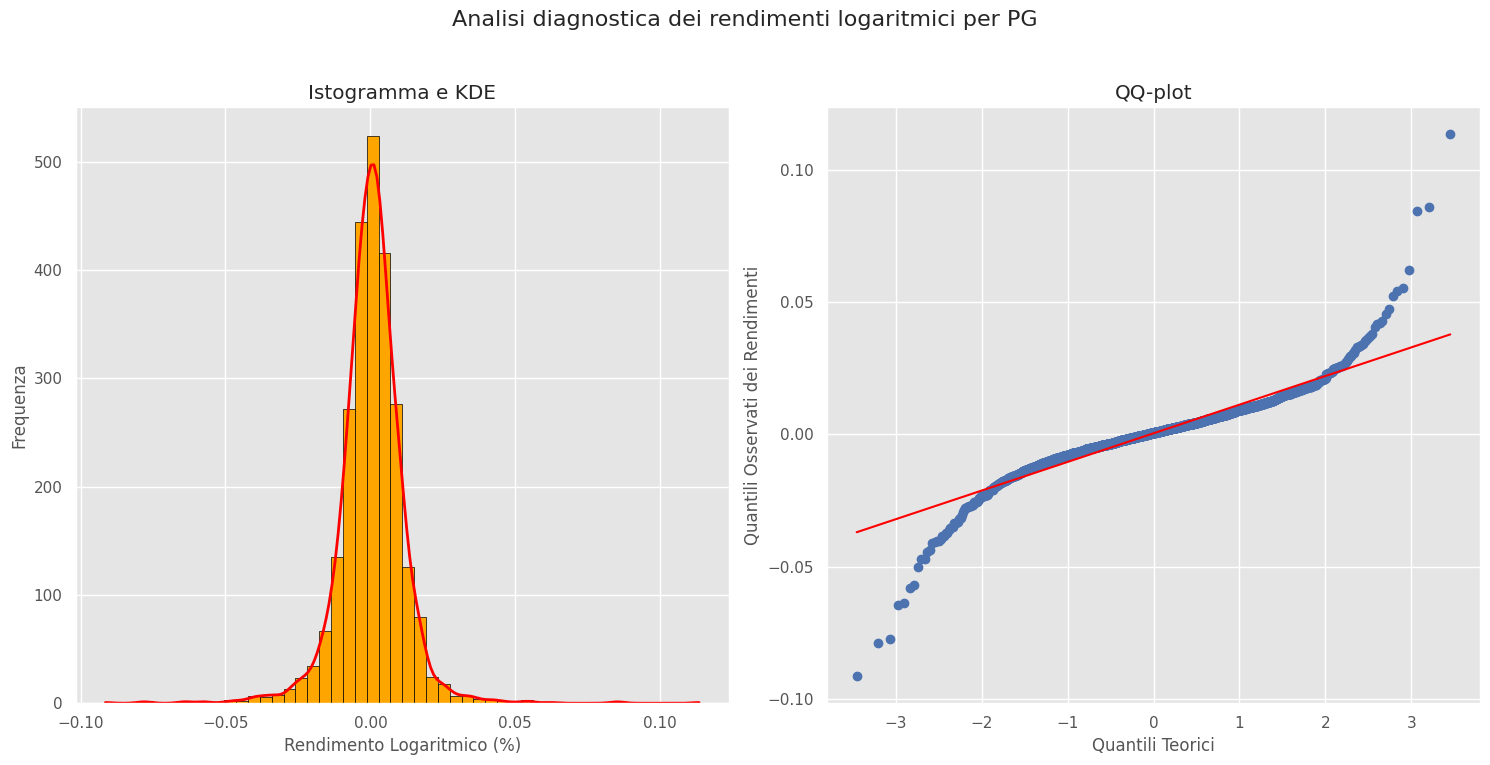

Analisi per PG:
I dati sono relativamente simmetrici.
I dati hanno una curtosi elevata, indicando la presenza di outlier.


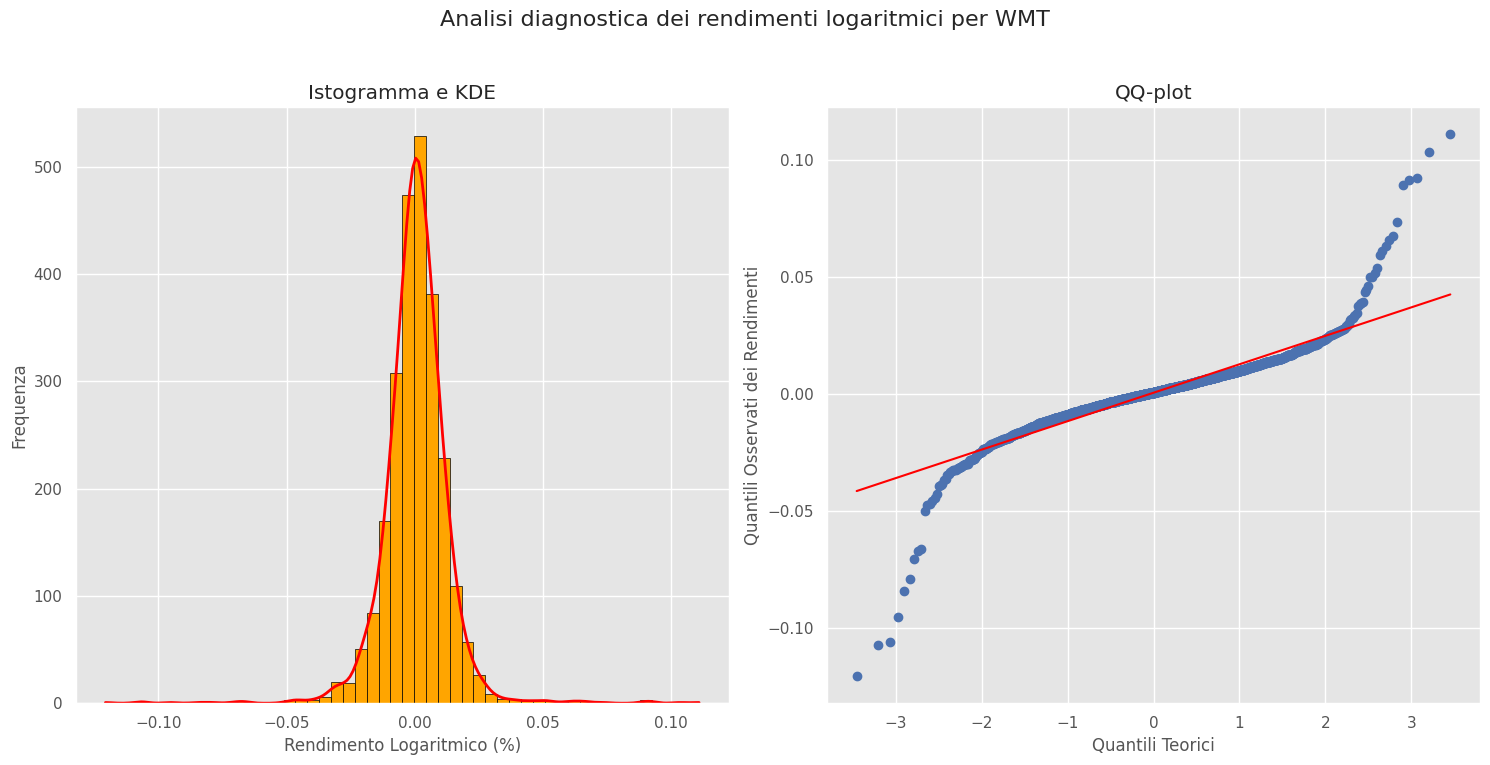

Analisi per WMT:
I dati sono relativamente simmetrici.
I dati hanno una curtosi elevata, indicando la presenza di outlier.


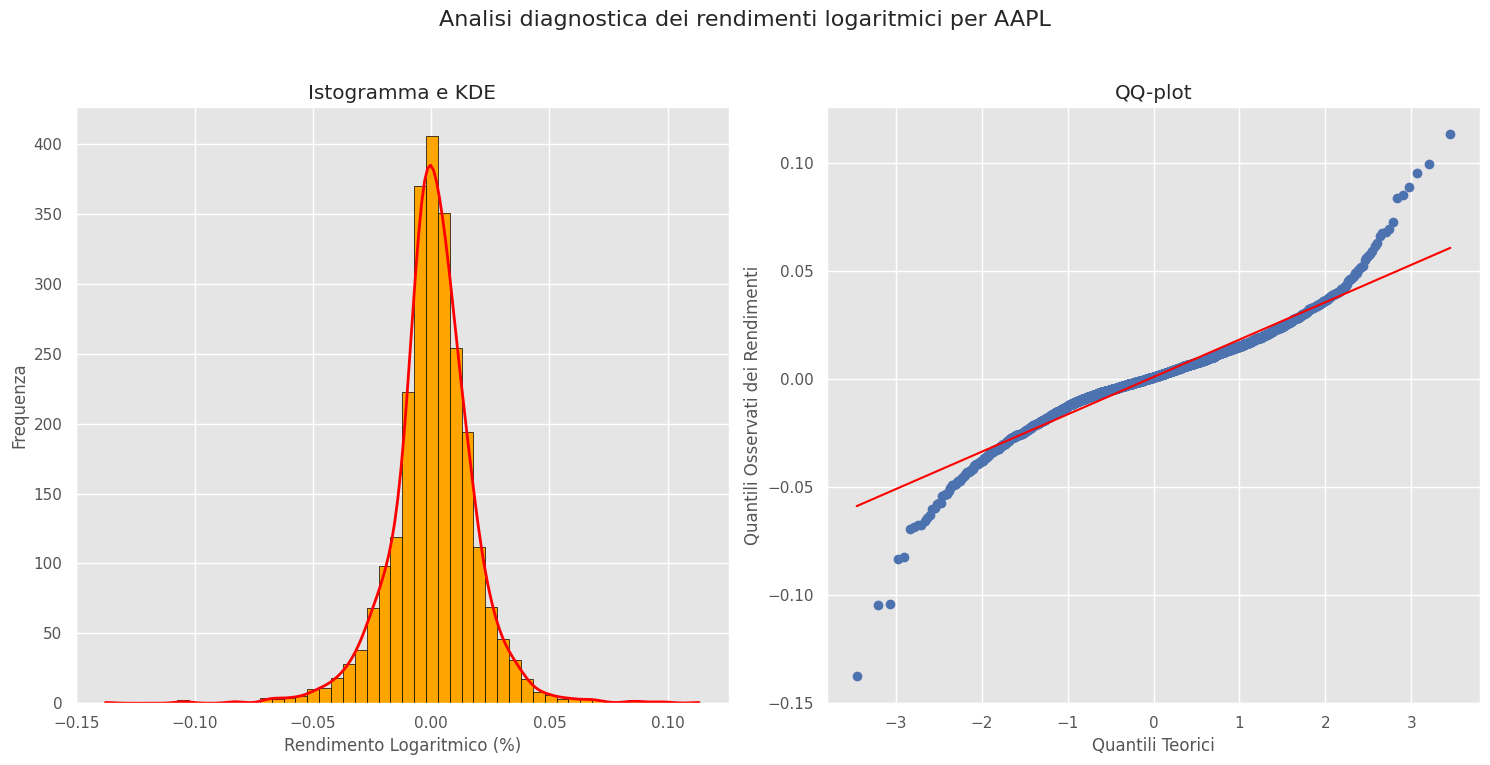

Analisi per AAPL:
I dati sono relativamente simmetrici.
I dati hanno una curtosi elevata, indicando la presenza di outlier.


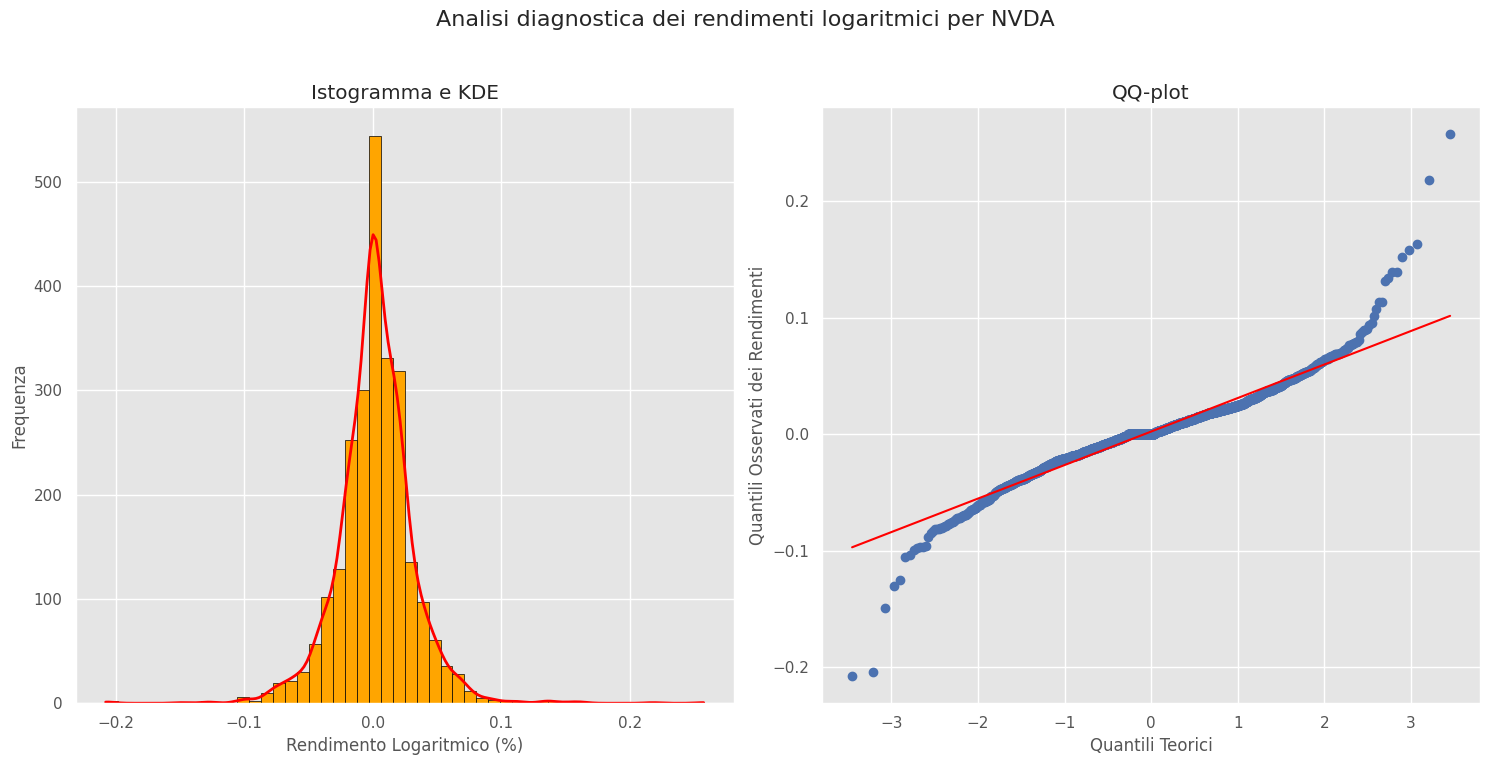

Analisi per NVDA:
I dati sono relativamente simmetrici.
I dati hanno una curtosi elevata, indicando la presenza di outlier.


In [33]:
# Ciclo per ciascun ticker
for ticker in tickers:
    fig, axes = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle(f'Analisi diagnostica dei rendimenti logaritmici per {ticker}', fontsize=16)

    # Dati per il ticker corrente
    data = returns_df[f'{ticker} RL'].dropna()  # Rimuovi NaN per analisi accurate

    # Istogramma e KDE (Kernel Density Estimate)
    sns.histplot(data, kde=True, ax=axes[0], color="red", bins=50,
                 line_kws={'lw': 2}, facecolor='orange', edgecolor='black')  # Utilizzo line_kws per personalizzare la linea KDE
    axes[0].set_title('Istogramma e KDE')
    axes[0].set_xlabel('Rendimento Logaritmico (%)')
    axes[0].set_ylabel('Frequenza')

    # QQ-plot
    stats.probplot(data, dist="norm", plot=axes[1])
    axes[1].get_lines()[1].set_color('red')
    axes[1].set_title('QQ-plot')
    axes[1].set_xlabel('Quantili Teorici')
    axes[1].set_ylabel('Quantili Osservati dei Rendimenti')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include the suptitle
    plt.show()

    # Commenti sui risultati -- Da togliere
    print(f"Analisi per {ticker}:")
    if data.skew() < -0.5 or data.skew() > 0.5:
        print("I dati mostrano una distribuzione asimmetrica.")
    else:
        print("I dati sono relativamente simmetrici.")

    if data.kurtosis() > 3:
        print("I dati hanno una curtosi elevata, indicando la presenza di outlier.")
    else:
        print("I dati hanno una curtosi moderata.")


f. Calcolare statistiche descrittive univariate (media, varianza, deviazione standard,
asimmetria, curtosi) per ogni serie di rendimenti e commentare.
i. Quali azioni hanno il rendimento più basso e più alto?
ii. quali azioni hanno la deviazione standard più alta o più bassa?
iii. come si evolvono nel tempo rendimento e volatilità?
iv. quale azione ha la distribuzione di rendimenti più vicina o lontana dalla
normale?


In [34]:
# Preparazione del DataFrame per contenere le statistiche
stats_df = pd.DataFrame(index=tickers)

# Ciclo per ogni ticker
for ticker in tickers:
    # Selezione dei dati di rendimento logaritimico per il ticker corrente
    data = returns_df[f'{ticker} RL'].dropna()  # Rimuovi NaN

    # Calcolo delle statistiche
    stats_df.loc[ticker, 'Media'] = data.mean()
    stats_df.loc[ticker, 'Varianza'] = data.var()
    stats_df.loc[ticker, 'Deviazione Standard'] = data.std()
    stats_df.loc[ticker, 'Asimmetria'] = data.skew()
    stats_df.loc[ticker, 'Curtosi'] = data.kurtosis()

stats_df.round(4)

Media  Varianza  Deviazione Standard  Asimmetria  Curtosi
AMZN  0.0010    0.0004               0.0206      0.1267   5.9907
MCD   0.0005    0.0002               0.0127     -0.1516  32.1362
PG    0.0004    0.0001               0.0115      0.0062  12.2439
WMT   0.0005    0.0002               0.0132     -0.2200  16.4201
AAPL  0.0009    0.0003               0.0178     -0.2156   5.5198
NVDA  0.0022    0.0009               0.0298      0.2275   7.2888

In [35]:
# Risposte alle domande specifiche
# i. Rendimento più alto e più basso
highest_return = stats_df['Media'].idxmax()
lowest_return = stats_df['Media'].idxmin()

# ii. Deviazione standard più alta e più bassa
highest_volatility = stats_df['Deviazione Standard'].idxmax()
lowest_volatility = stats_df['Deviazione Standard'].idxmin()

# iii. Analisi dell'evoluzione di rendimento e volatilità (grafici)
# iv. Azione con distribuzione di rendimenti più vicina o lontana dalla normale
most_normal = stats_df['Asimmetria'].abs().idxmin()  # Presupponiamo che la distribuzione più simmetrica sia la più normale

print(f"L'azione con il rendimento medio più alto: {highest_return}")
print(f"L'azione con il rendimento medio più basso: {lowest_return}")
print(f"L'azione con la deviazione standard più alta (più volatile): {highest_volatility}")
print(f"L'azione con la deviazione standard più bassa (meno volatile): {lowest_volatility}")
print(f"L'azione con la distribuzione di rendimenti più vicina alla normale: {most_normal}")

L'azione con il rendimento medio più alto: NVDA
L'azione con il rendimento medio più basso: PG
L'azione con la deviazione standard più alta (più volatile): NVDA
L'azione con la deviazione standard più bassa (meno volatile): PG
L'azione con la distribuzione di rendimenti più vicina alla normale: PG


g. Calcolare la matrice di varianze/covarianze e di correlazione dei rendimenti. Sulla base
della matrice di correlazioni:

In [36]:
# Preparazione del DataFrame contenente solo i rendimenti logaritmici
log_returns = returns_df.filter(regex='RL$')

# Calcolo della matrice di covarianza annualizzata
covariance_matrix = (log_returns*252).cov()

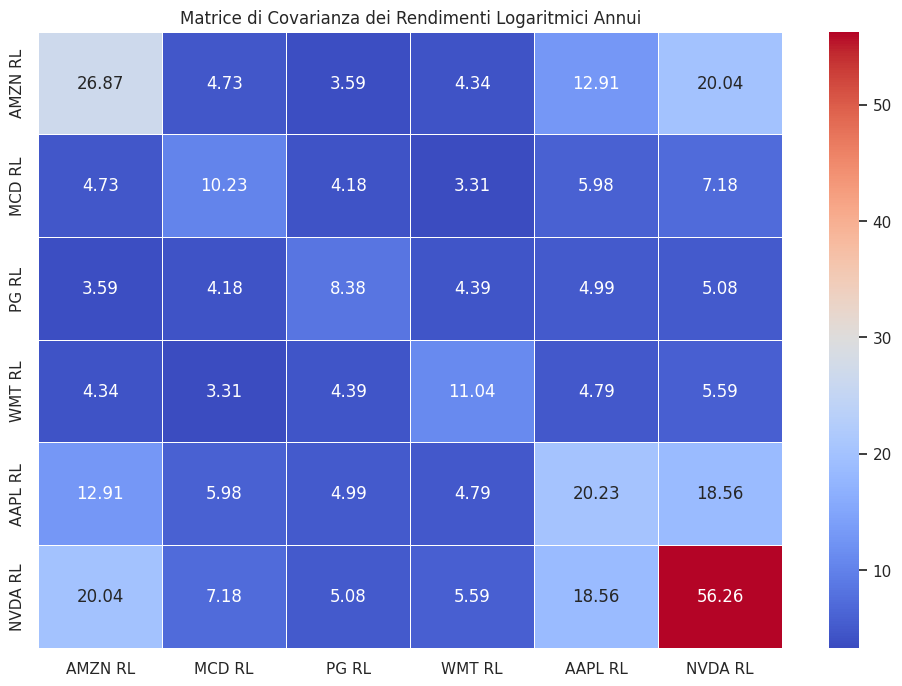

In [37]:
# Configurazione dell'ambiente grafico
sns.set(style="whitegrid")
# Visualizzazione della matrice di covarianza
plt.figure(figsize=(12, 8))
sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)
plt.title('Matrice di Covarianza dei Rendimenti Logaritmici Annui')
plt.show()

g. i. Quali sono i titoli più correlati?
ii. Quali i meno correlati?


In [38]:
correlation_matrix = log_returns.corr()

# Identificazione dei titoli più e meno correlati
# i. Titoli più correlati
max_corr = 0
pair_most_corr = ('', '')

for i in correlation_matrix.columns:
    for j in correlation_matrix.index:
        if i != j:  # Evitiamo di confrontare un titolo con se stesso
            if correlation_matrix.loc[i, j] > max_corr:
                max_corr = correlation_matrix.loc[i, j]
                pair_most_corr = (i, j)

# ii. Titoli meno correlati
min_corr = 1
pair_least_corr = ('', '')

for i in correlation_matrix.columns:
    for j in correlation_matrix.index:
        if i != j:  # Evitiamo di confrontare un titolo con se stesso
            if correlation_matrix.loc[i, j] < min_corr:
                min_corr = correlation_matrix.loc[i, j]
                pair_least_corr = (i, j)

print(f"\nI titoli più correlati sono {pair_most_corr[0]} e {pair_most_corr[1]} con una correlazione di {max_corr:.2f}")
print(f"I titoli meno correlati sono {pair_least_corr[0]} e {pair_least_corr[1]} con una correlazione di {min_corr:.2f}")


I titoli più correlati sono AMZN RL e AAPL RL con una correlazione di 0.55
I titoli meno correlati sono WMT RL e NVDA RL con una correlazione di 0.22


In [39]:
# Calcolo max e min correlazione
max_val = correlation_matrix.values.max()
min_val = correlation_matrix.values.min()

# Calcolo di un limite ragionevole per la scala dei colori
color_limit = max(abs(max_val), abs(min_val))

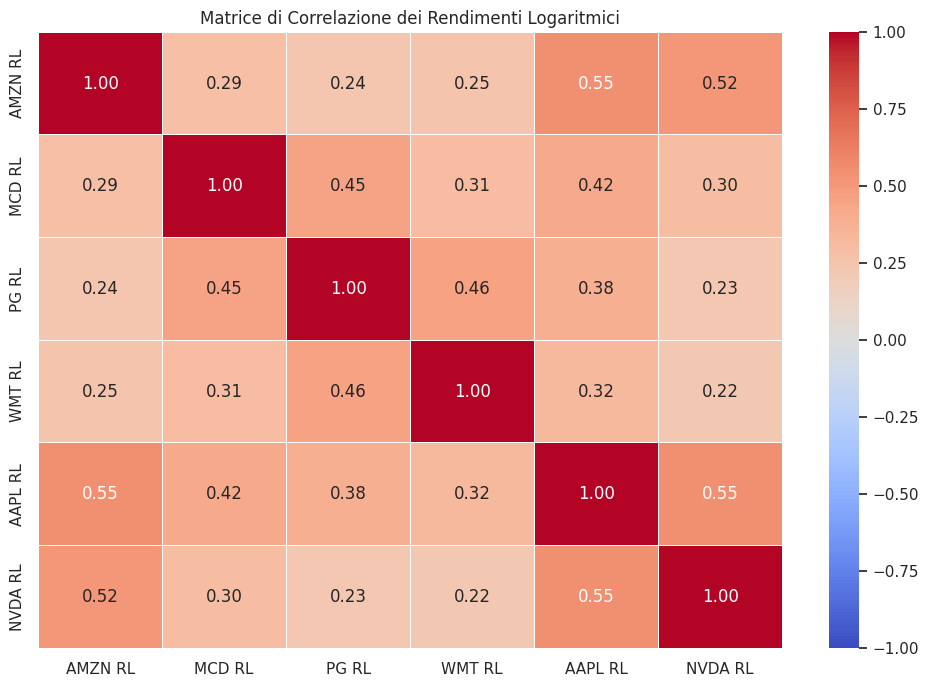

In [40]:

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5, center=0, vmin=-color_limit, vmax=color_limit)
plt.title('Matrice di Correlazione dei Rendimenti Logaritmici')
plt.show()

In [41]:
# Calcolo delle correlazioni mobili
rolling_correlations = log_returns.rolling(window=252).corr().dropna()

h. Fare il grafico dell’andamento nel tempo delle correlazioni fra i titoli

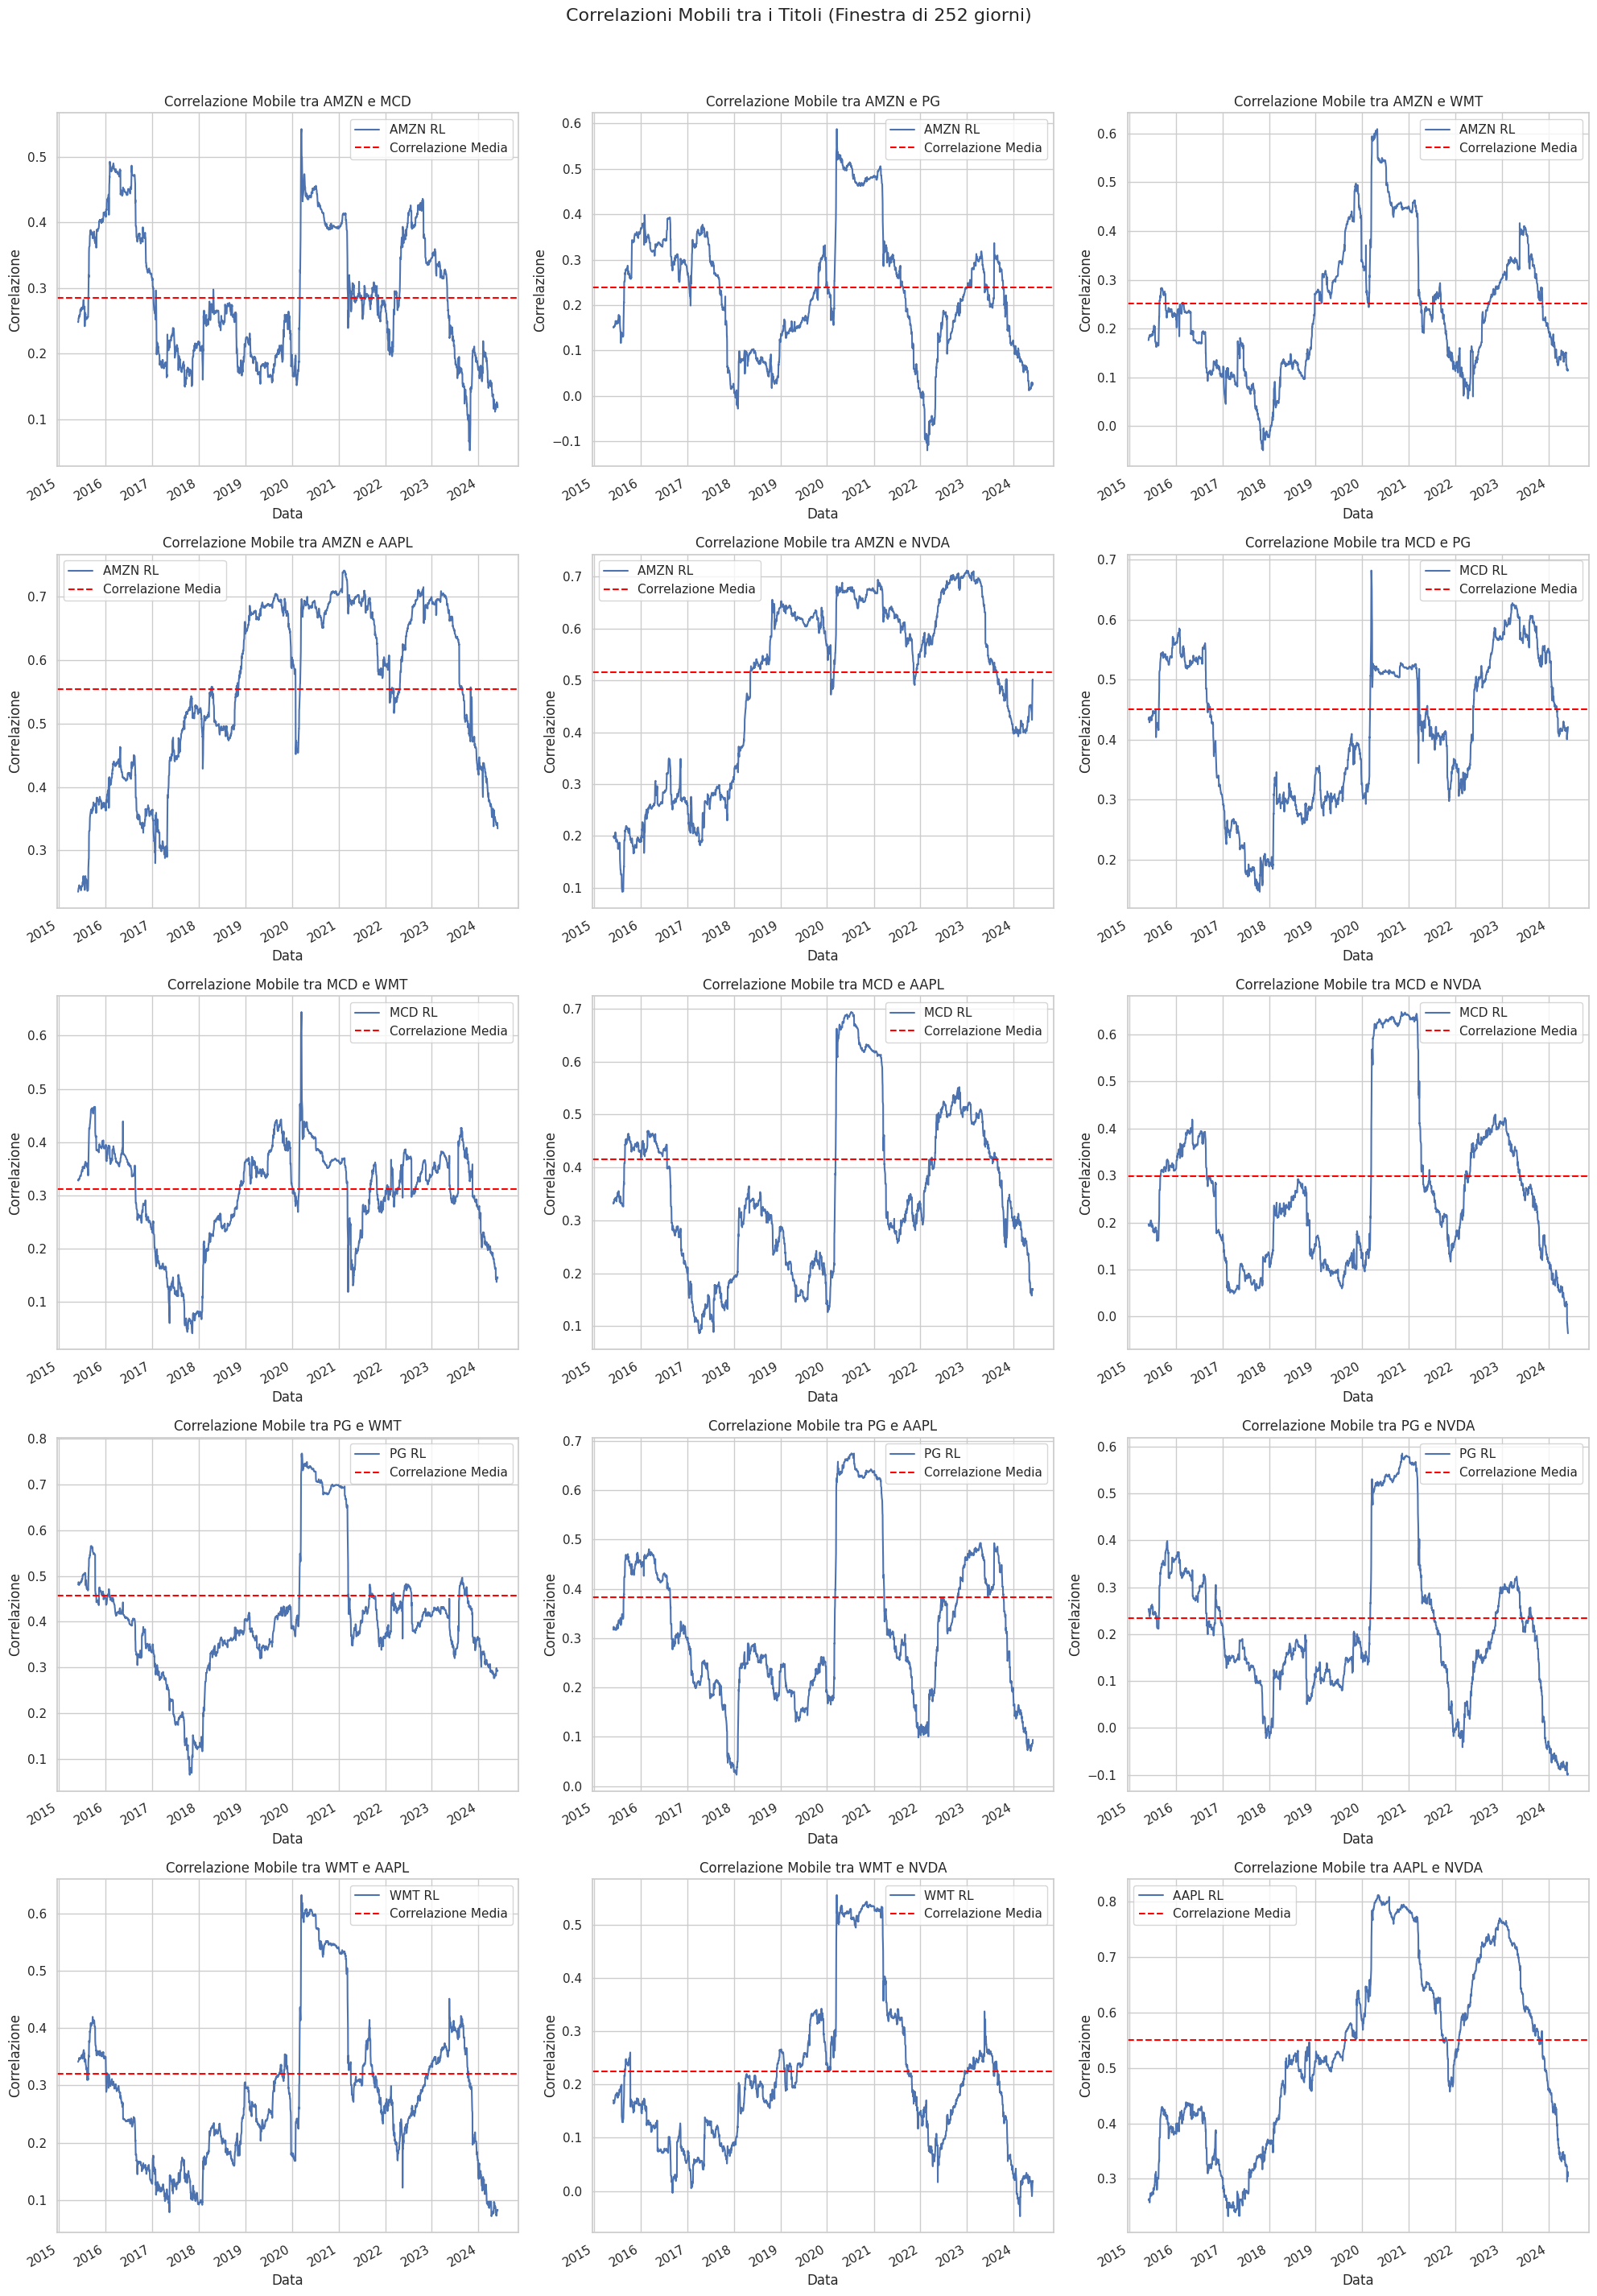

In [42]:
# Preparazione della griglia di grafici
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 30))
axes = axes.flatten()  # Converti l'array 2D di assi in un array 1D

# Grafico delle correlazioni mobili per ogni coppia di titoli
plot_idx = 0
for i in range(len(tickers)):
    for j in range(i + 1, len(tickers)):
        ticker_i = tickers[i]
        ticker_j = tickers[j]

        if f'{ticker_i} RL' in rolling_correlations.columns and f'{ticker_j} RL' in rolling_correlations.columns:
            rolling_corr_pair = rolling_correlations[f'{ticker_i} RL'].loc[:, f'{ticker_j} RL']

            # Estrai la correlazione media dalla matrice di correlazione
            mean_correlation = correlation_matrix.loc[f'{ticker_i} RL', f'{ticker_j} RL']

            ax = axes[plot_idx]
            rolling_corr_pair.plot(ax=ax, title=f'Correlazione Mobile tra {ticker_i} e {ticker_j}')
            ax.axhline(mean_correlation, color='red', linestyle='--', label='Correlazione Media')
            ax.set_xlabel('Data')
            ax.set_ylabel('Correlazione')
            ax.legend()
            plot_idx += 1

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to include the suptitle
plt.suptitle('Correlazioni Mobili tra i Titoli (Finestra di 252 giorni)', fontsize=16)
plt.show()

In [43]:
sectors = {
    'XLY': ['AMZN', 'MCD'],  # I corrected 'AMZ' to 'AMZN' and 'MDC' to 'MCD'
    'XLP': ['PG', 'WMT'],
    'XLK': ['AAPL', 'NVDA']
}

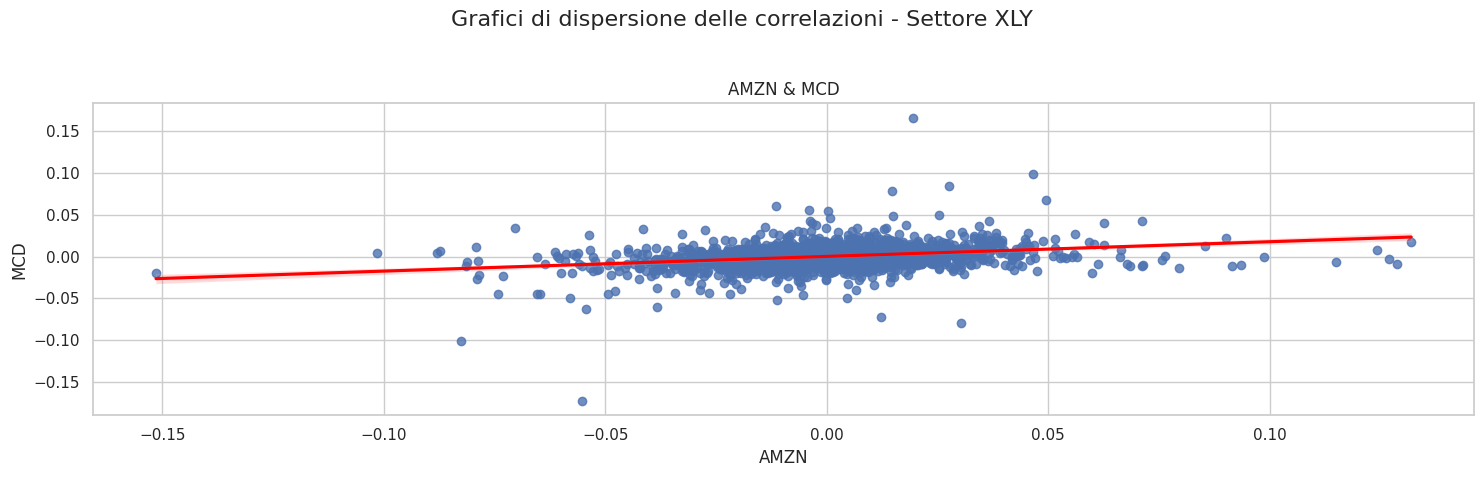

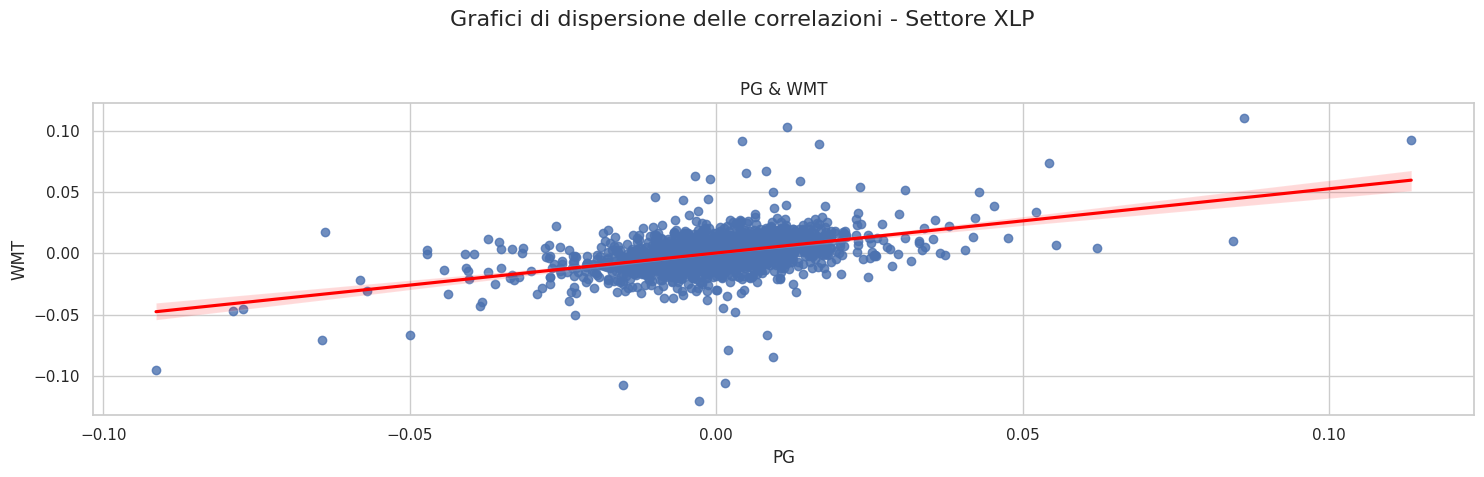

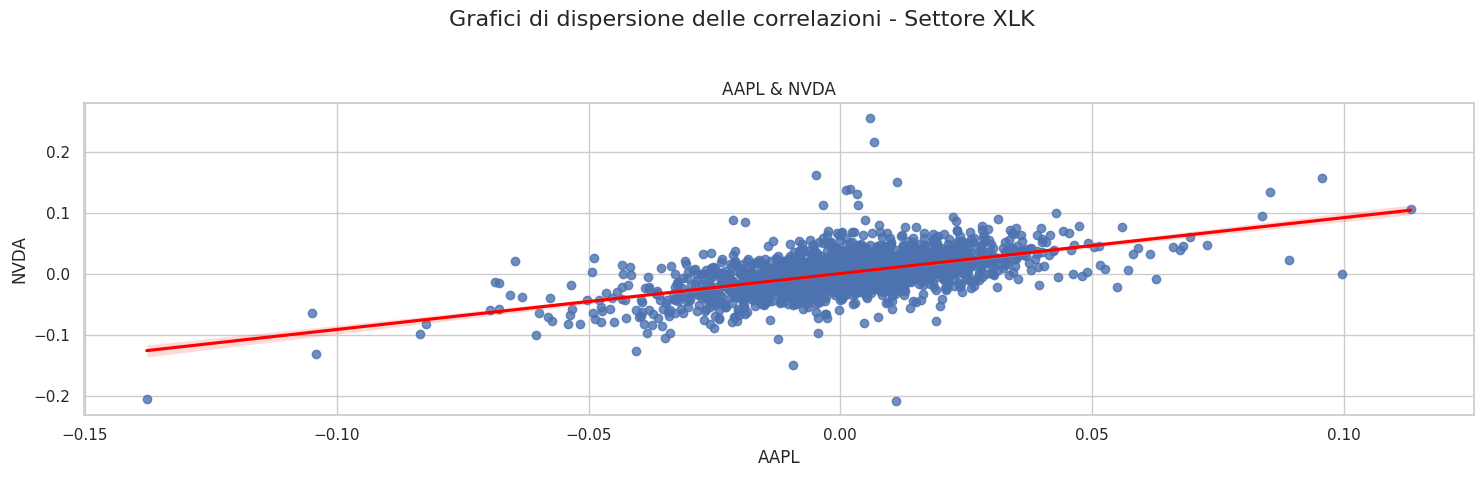

In [44]:
# Creazione dei grafici di dispersione per ciascun settore
for sector, tickers in sectors.items():
    fig, axes = plt.subplots(1, len(tickers) - 1, figsize=(15, 5))
    fig.suptitle(f'Grafici di dispersione delle correlazioni - Settore {sector}', fontsize=16)

    for i in range(len(tickers)):
        for j in range(i + 1, len(tickers)):
            ticker_i = tickers[i]
            ticker_j = tickers[j]
            ax = axes[i] if len(tickers) > 2 else axes

            sns.regplot(x=log_returns[f'{ticker_i} RL'], y=log_returns[f'{ticker_j} RL'], ax=ax, line_kws={"color": "red"})
            ax.set_title(f'{ticker_i} & {ticker_j}')
            ax.set_xlabel(ticker_i)
            ax.set_ylabel(ticker_j)
            ax.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

 # 3. Analisi di previsione

In [45]:
df_settle = adjusted_close_df.resample('M').last() #rendimento mensile di ogni titolo

In [72]:
def arima_grid_search(dataframe, s):
    p = d = q = range(2)  # Definizione dei range per p, d, q
    param_combinations = list(itertools.product(p, d, q))
    lowest_aic, pdq, pdqs = None, None, None
    total_iterations = 0

    for order in param_combinations:
        for seasonal_order in [(x[0], x[1], x[2], s) for x in param_combinations]:
            try:
                model = SARIMAX(dataframe, order=order, seasonal_order=seasonal_order)
                model_result = model.fit(disp=False)
                if lowest_aic is None or model_result.aic < lowest_aic:
                    lowest_aic = model_result.aic
                    pdq, pdqs = order, seasonal_order
            except Exception as ex:
                print(f"Error with order {order} and seasonal order {seasonal_order}: {ex}")
                continue

    return lowest_aic, pdq, pdqs

In [66]:
hyperparams = {}
tickers = ["AMZN", "MCD", "PG", "WMT", "AAPL", "NVDA"] # Lo riscrivo perchè non è stato definito in questo script
for name in tickers:
    print(f"Optimizing ARIMA parameters for {name}")
    hyperparams[name] = arima_grid_search(df_settle[name].dropna(), 12)  # Presumiendo 12 come periodo stagionale

print("Optimization Complete!")
hyperparams

Optimizing ARIMA parameters for AMZN
Optimizing ARIMA parameters for MCD
Optimizing ARIMA parameters for PG
Optimizing ARIMA parameters for WMT
Optimizing ARIMA parameters for AAPL
Optimizing ARIMA parameters for NVDA
Optimization Complete!


{'AMZN': (804.6486719393395, (0, 1, 0), (0, 1, 1, 12)),
 'MCD': (807.6593652273127, (1, 1, 1), (0, 1, 1, 12)),
 'PG': (672.8724911994475, (0, 1, 0), (0, 1, 1, 12)),
 'WMT': (474.81979907842054, (0, 1, 0), (0, 1, 1, 12)),
 'AAPL': (773.9761782259183, (0, 1, 0), (0, 1, 1, 12)),
 'NVDA': (562.7042541762208, (1, 1, 1), (1, 1, 0, 12))}

In [67]:
# Calcola le date di cut-off per il training e il validation
train_end = df_settle.index.min() + pd.DateOffset(months=80)
validation_end = train_end + pd.DateOffset(months=30)

# Dividi i dati in training e validation
train_data = {}
validation_data = {}
for ticker in tickers:
    train_data[ticker] = df_settle[ticker][:train_end]
    validation_data[ticker] = df_settle[ticker][train_end:validation_end]

# Addestramento del modello e predizioni per la fase di validation
models = {}
predictions_ic = {}
forecasted_vals = {}
for name in tickers:
    # Adatta il modello SARIMAX ai dati di training
    model = SARIMAX(
        train_data[name],
        order=hyperparams[name][1],
        seasonal_order=hyperparams[name][2],
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False)
    models[name] = fitted_model

    # Calcola le previsioni per la fase di validation
    forecast_steps = len(validation_data[name])
    prediction_ci = fitted_model.get_prediction(start=train_end, end=validation_end).conf_int()
    forecasted_val = fitted_model.predict(start=train_end, end=validation_end)

    predictions_ic[name] = prediction_ci
    forecasted_vals[name] = forecasted_val

print("Models trained and predictions made.")

Models trained and predictions made.


In [49]:
predictions_ic = dict([]) # intervalli di confidenza
forecasted_vals = dict([]) # valori

for name in tickers:
    prediction_ci = models.get(name).get_prediction(start=110, end = 110+9).conf_int() # i.c. di 10 predizioni
    forecasted_val = models.get(name).predict(start=110, end = 110+9) # valori forecasted per gli ultimi 10 mesi

    predictions_ic.update({name:prediction_ci})
    forecasted_vals.update({name:forecasted_val})

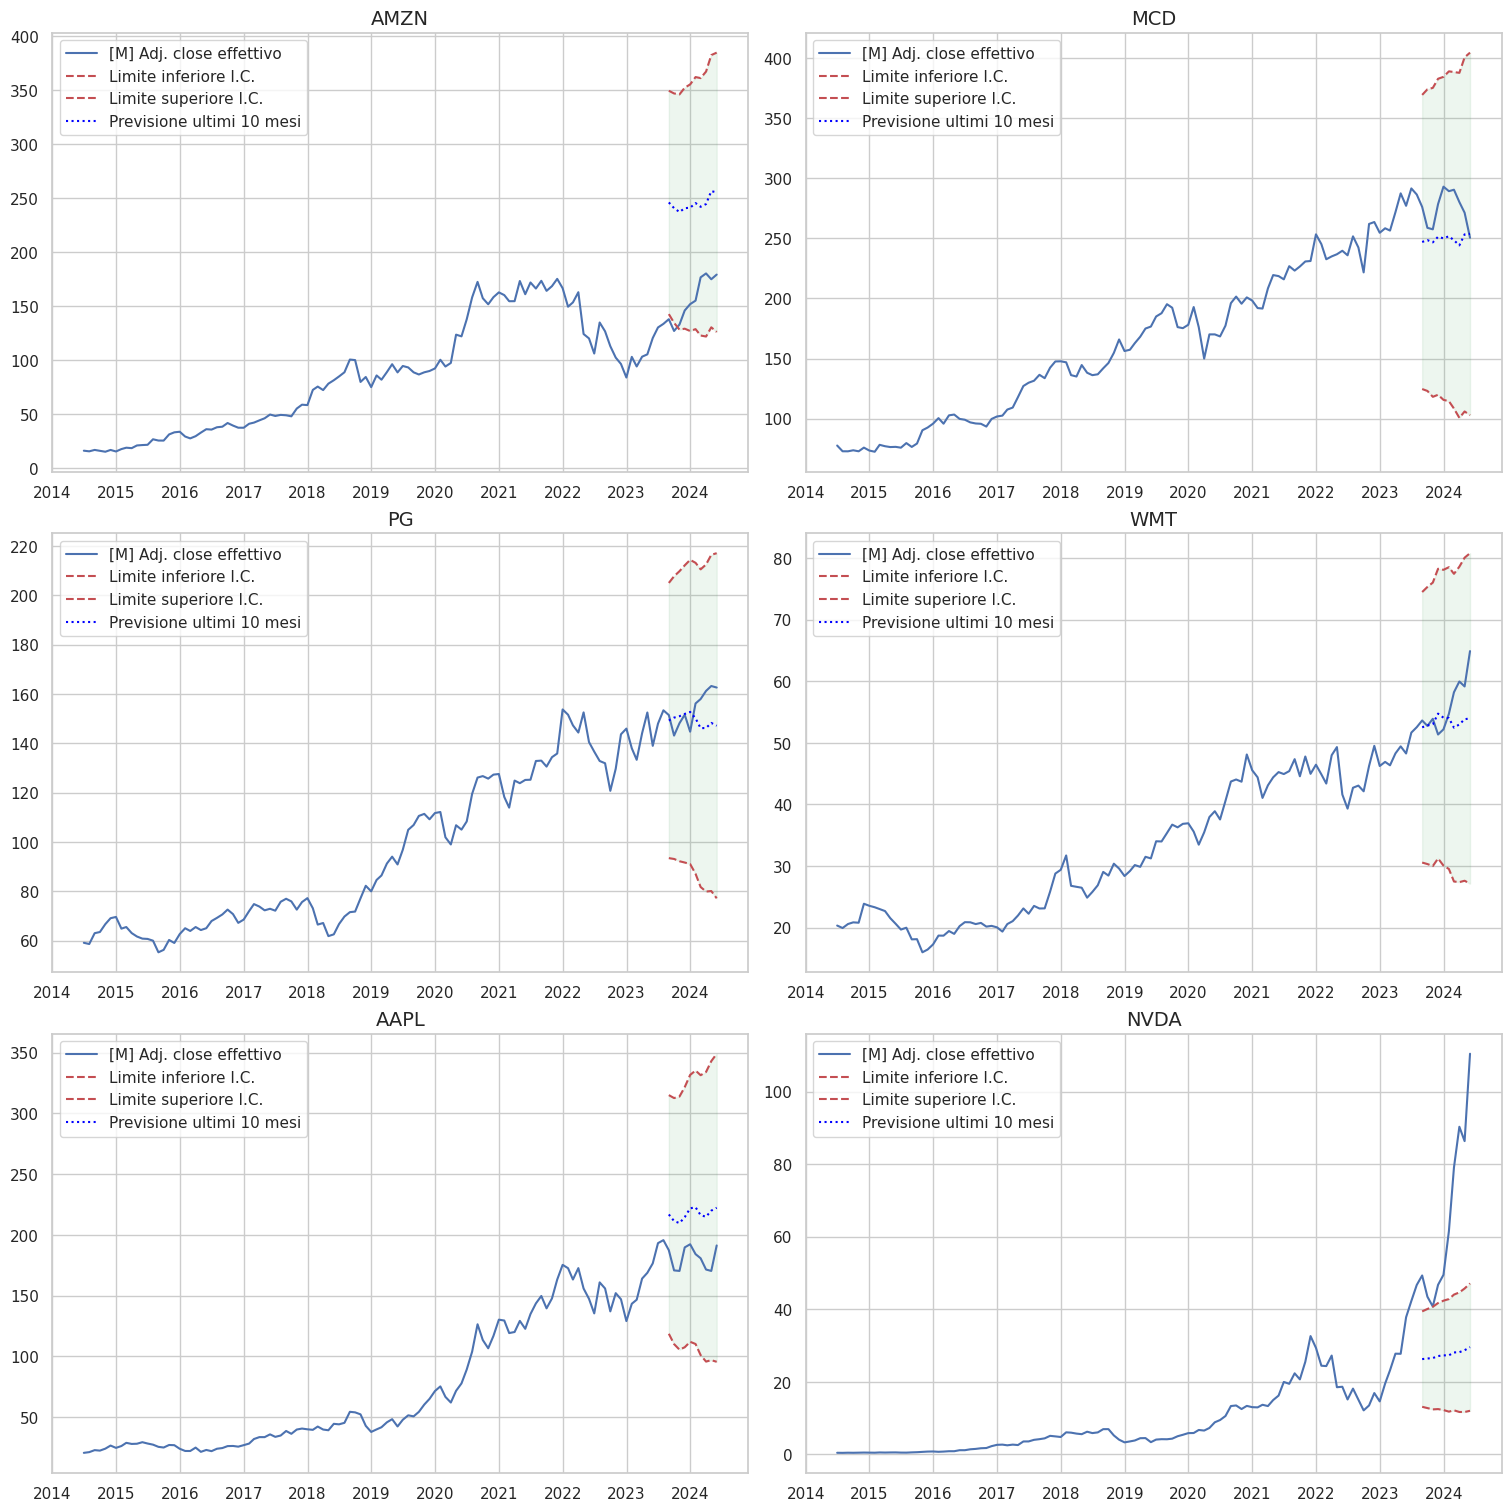

In [50]:
predictions_ic = {}  # intervalli di confidenza
forecasted_vals = {}  # valori

# Assicurati che il modello sia adatto e i modelli siano già stati creati
for name in tickers:
    prediction_ci = models.get(name).get_prediction(start=110, end=110+9).conf_int()  # I.C. di 10 predizioni
    forecasted_val = models.get(name).predict(start=110, end=110+9)  # Valori forecasted per gli ultimi 10 mesi

    predictions_ic[name] = prediction_ci
    forecasted_vals[name] = forecasted_val

(row, col) = (0, 0)

# Creazione della griglia di grafici
fig, axs = plt.subplots(3, 2, figsize=(15, 15), constrained_layout=True)

for name in tickers:
    ax = axs[row, col]

    col += 1
    if col == 2:
        col = 0
        row += 1

    ax.set_title(name, fontsize=14)

    # Grafico dei dati effettivi dal DataFrame 'df_settle'
    ax.plot(df_settle[name], label='[M] Adj. close effettivo')

    # Intervallo di confidenza
    ax.plot(predictions_ic[name].index, predictions_ic[name].iloc[:, 0], 'r--', label='Limite inferiore I.C.')
    ax.plot(predictions_ic[name].index, predictions_ic[name].iloc[:, 1], 'r--', label='Limite superiore I.C.')
    ax.fill_between(predictions_ic[name].index,
                    predictions_ic[name].iloc[:, 0],
                    predictions_ic[name].iloc[:, 1],
                    color='g', alpha=0.1)

    # Forecast degli ultimi 10 mesi
    ax.plot(forecasted_vals[name], label='Previsione ultimi 10 mesi', color='blue', linestyle='dotted')

    ax.grid(True)
    ax.legend()

plt.show()


Per ogni ticker Calcolo di MSE e RMSE, ultimi 10 mesi

In [51]:
mse_scores = {}
rmse_scores = {}

for name in tickers:
    actual_vals = df_settle[name][-10:]  # Prendi gli ultimi 10 mesi di dati effettivi
    predicted_vals = forecasted_vals[name]  # Prendi le previsioni corrispondenti

    # Calcolo di MSE
    mse = mean_squared_error(actual_vals, predicted_vals)
    mse_scores[name] = round(mse, 4)  # Arrotonda a 4 cifre decimali

    # Calcolo di RMSE
    rmse = sqrt(mse)
    rmse_scores[name] = round(rmse, 4)  # Arrotonda a 4 cifre decimali

    print(f"{name} - MSE: {mse_scores[name]}, RMSE: {rmse_scores[name]}")


AMZN - MSE: 8144.1254, RMSE: 90.2448
MCD - MSE: 845.9254, RMSE: 29.0848
PG - MSE: 99.5646, RMSE: 9.9782
WMT - MSE: 24.6823, RMSE: 4.9681
AAPL - MSE: 1362.2335, RMSE: 36.9084
NVDA - MSE: 1941.1501, RMSE: 44.0585


# 4 Stategie di trading e backtesting

a. Costruire una strategia di trading basata su un algoritmo a scelta che segnali l’acquisto
o la vendita di un titolo o indice di borsa e farne il backtesting
b. Misurare l’efficienza della strategia rispetto alla detenzione del titolo per tutto il periodo
(“Buy & Hold”);


Per semplicità, svilupperemo una strategia di trading basata sulle medie mobili incrociate. Questa strategia genera un segnale di 'acquisto' quando una media mobile a breve termine incrocia sopra una media mobile a lungo termine e un segnale di 'vendita' quando incrocia al di sotto.


In [52]:
# Scaricare tutti i dati in una sola volta
data_dict = {}
for ticker in tickers:
    data_dict[ticker] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


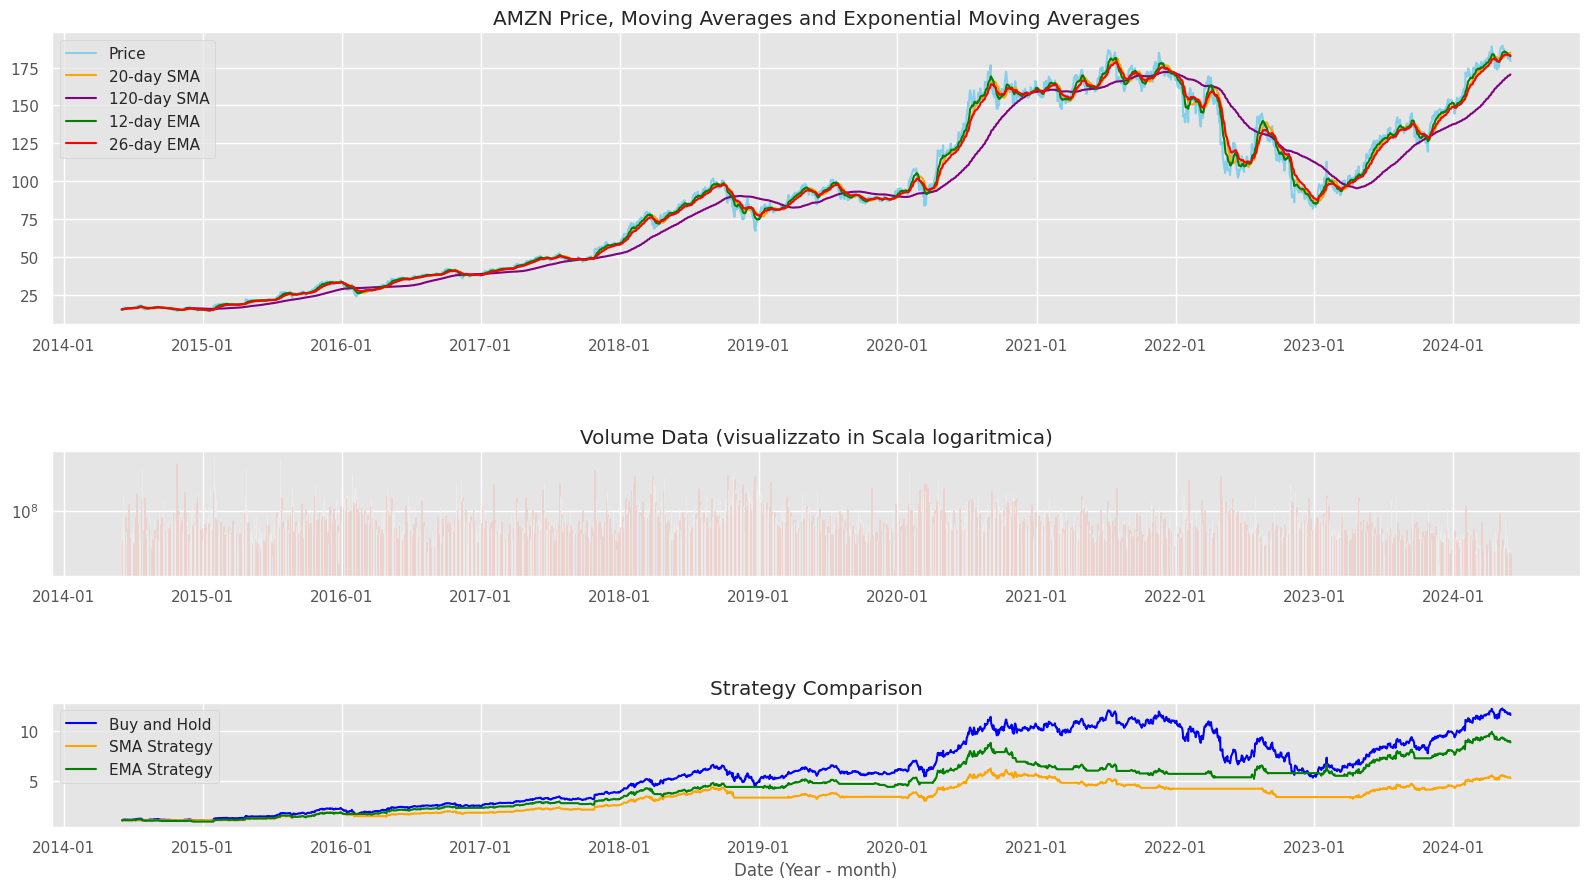

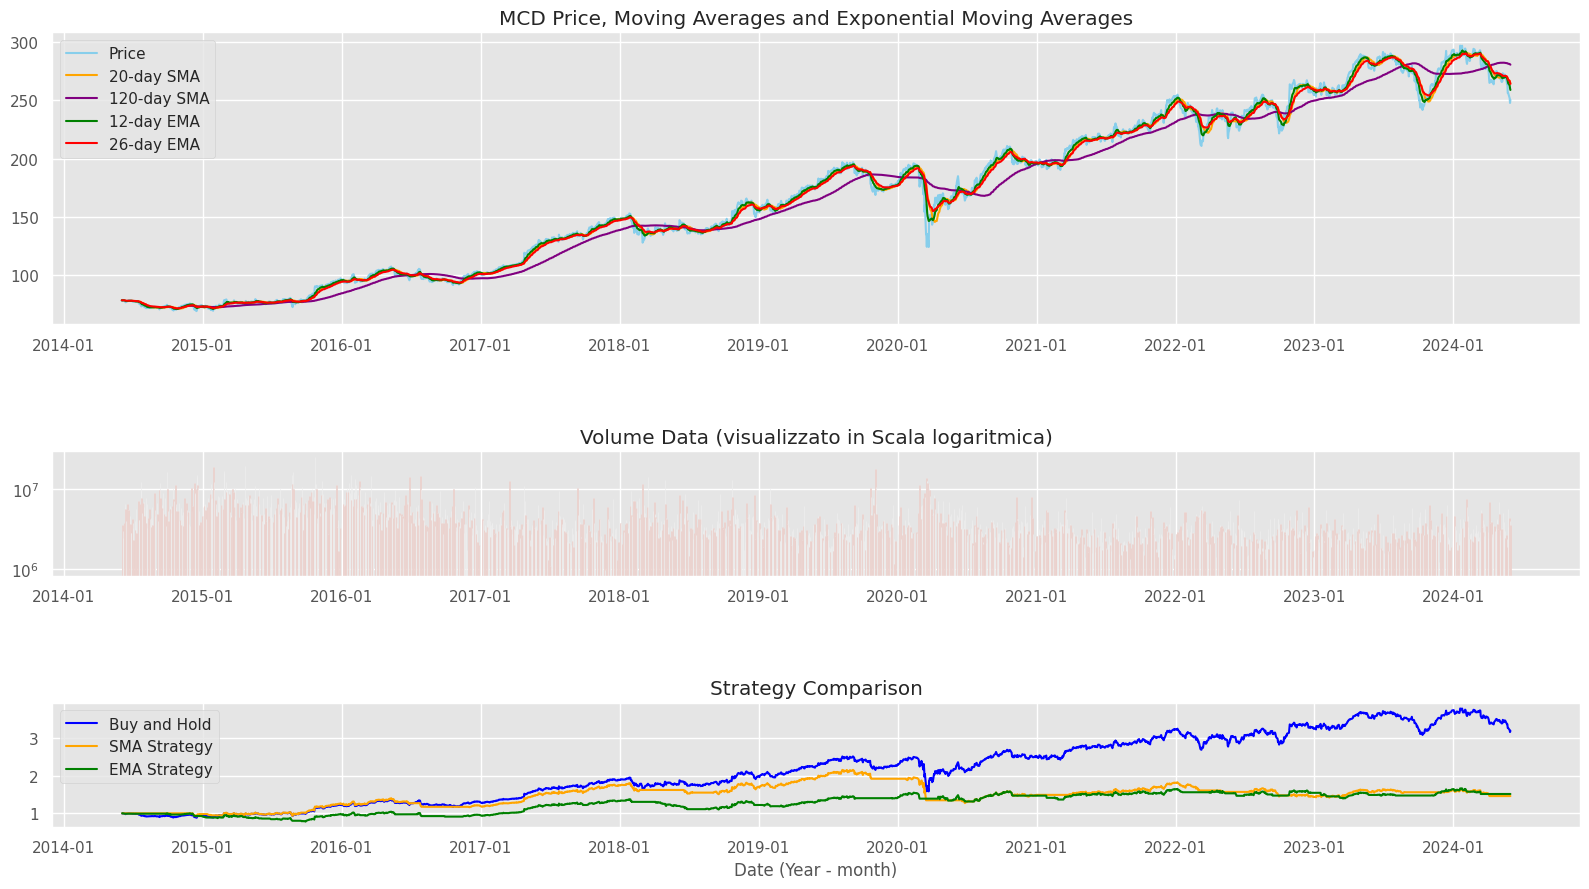

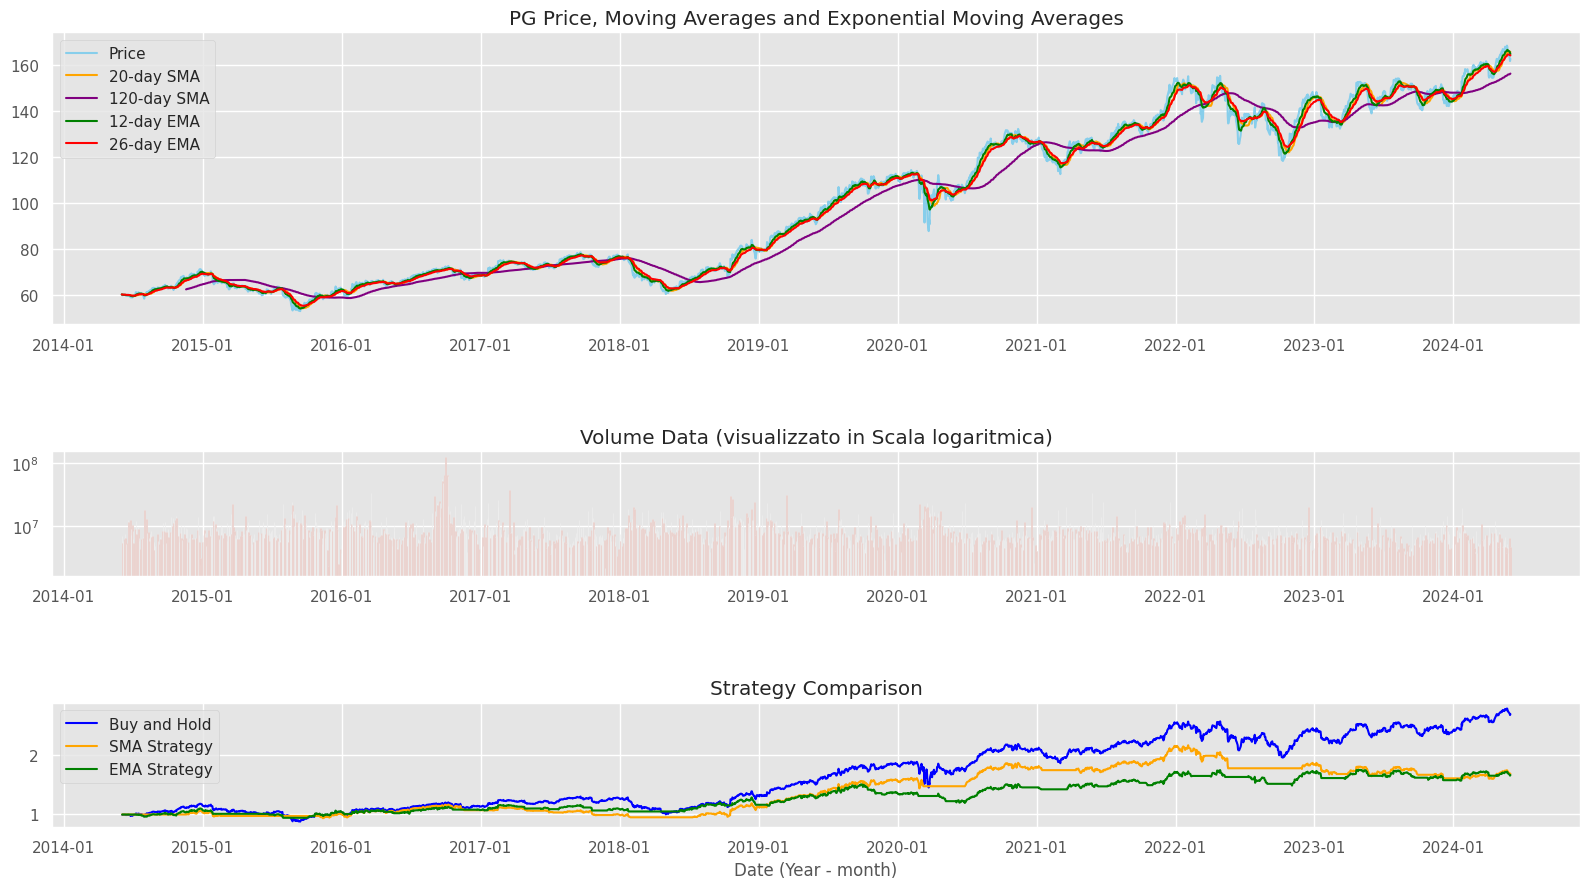

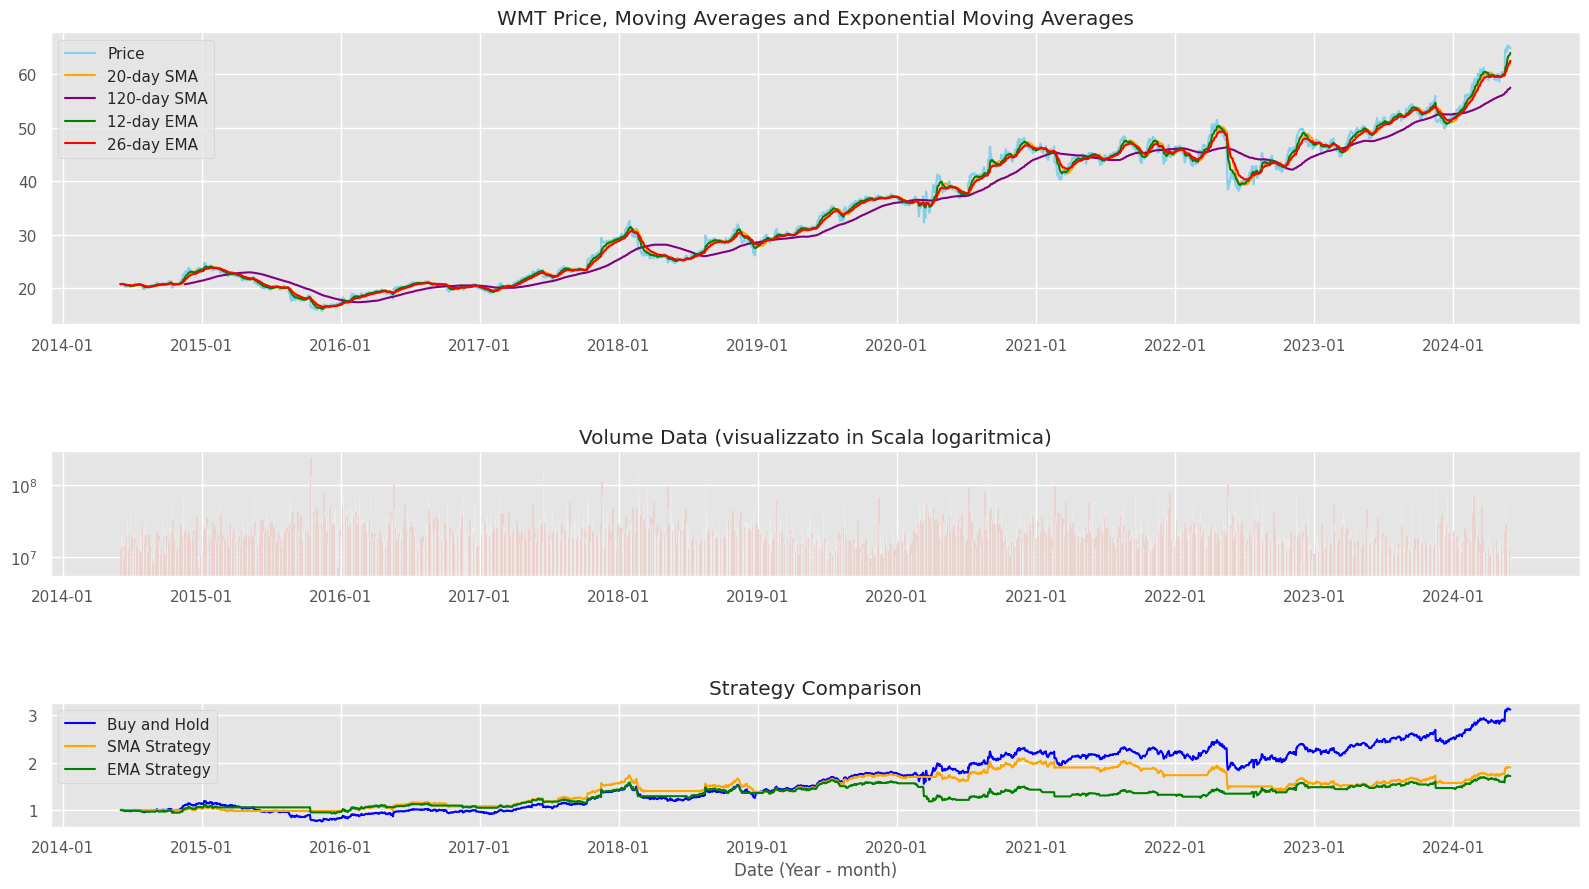

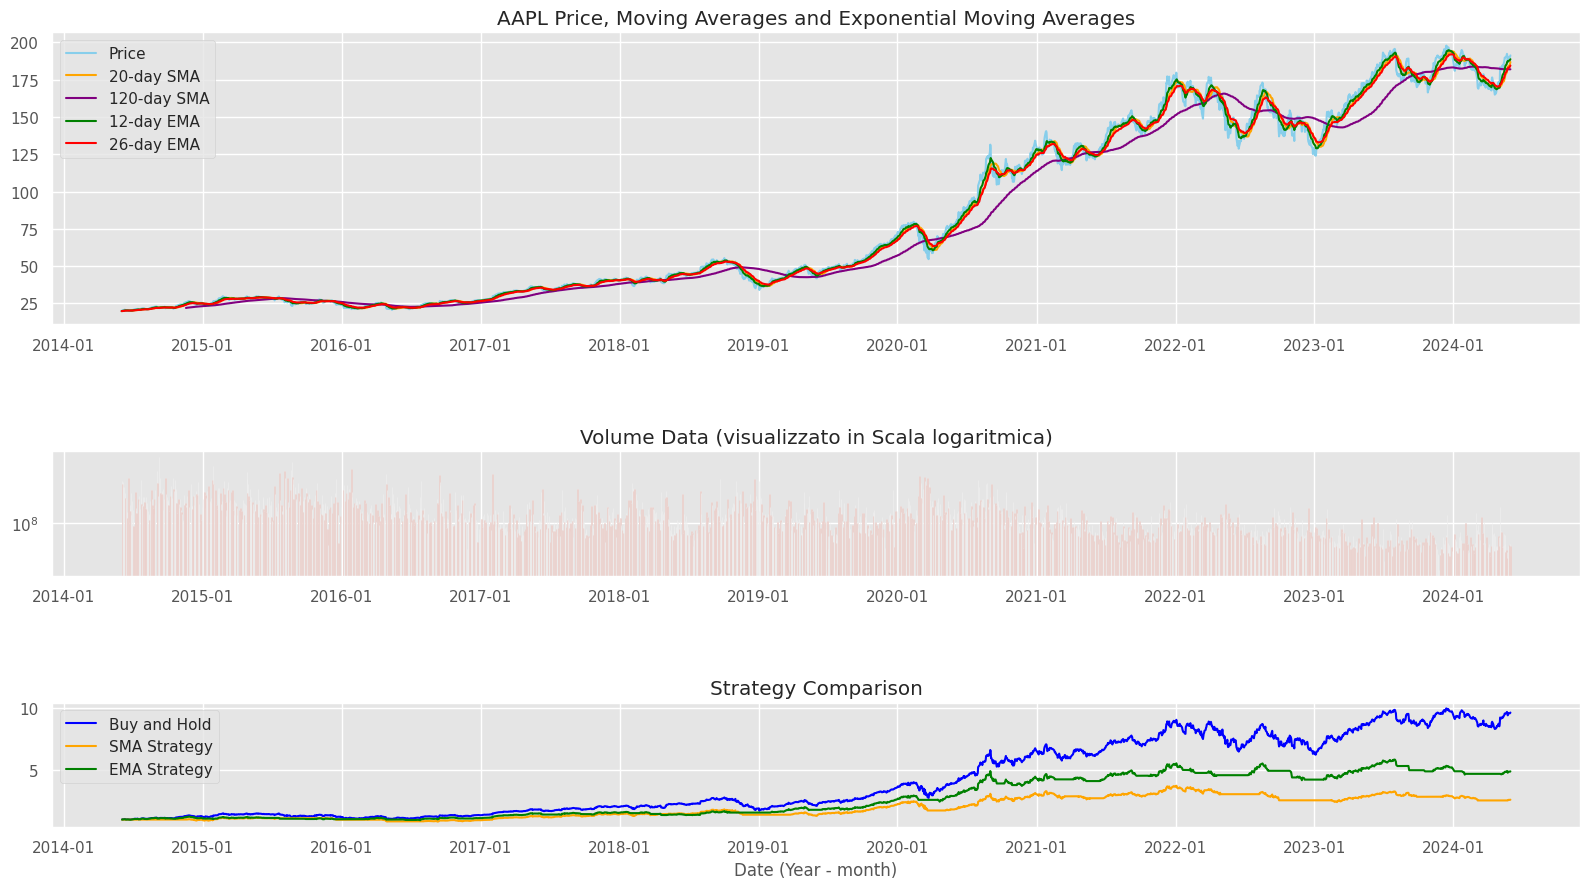

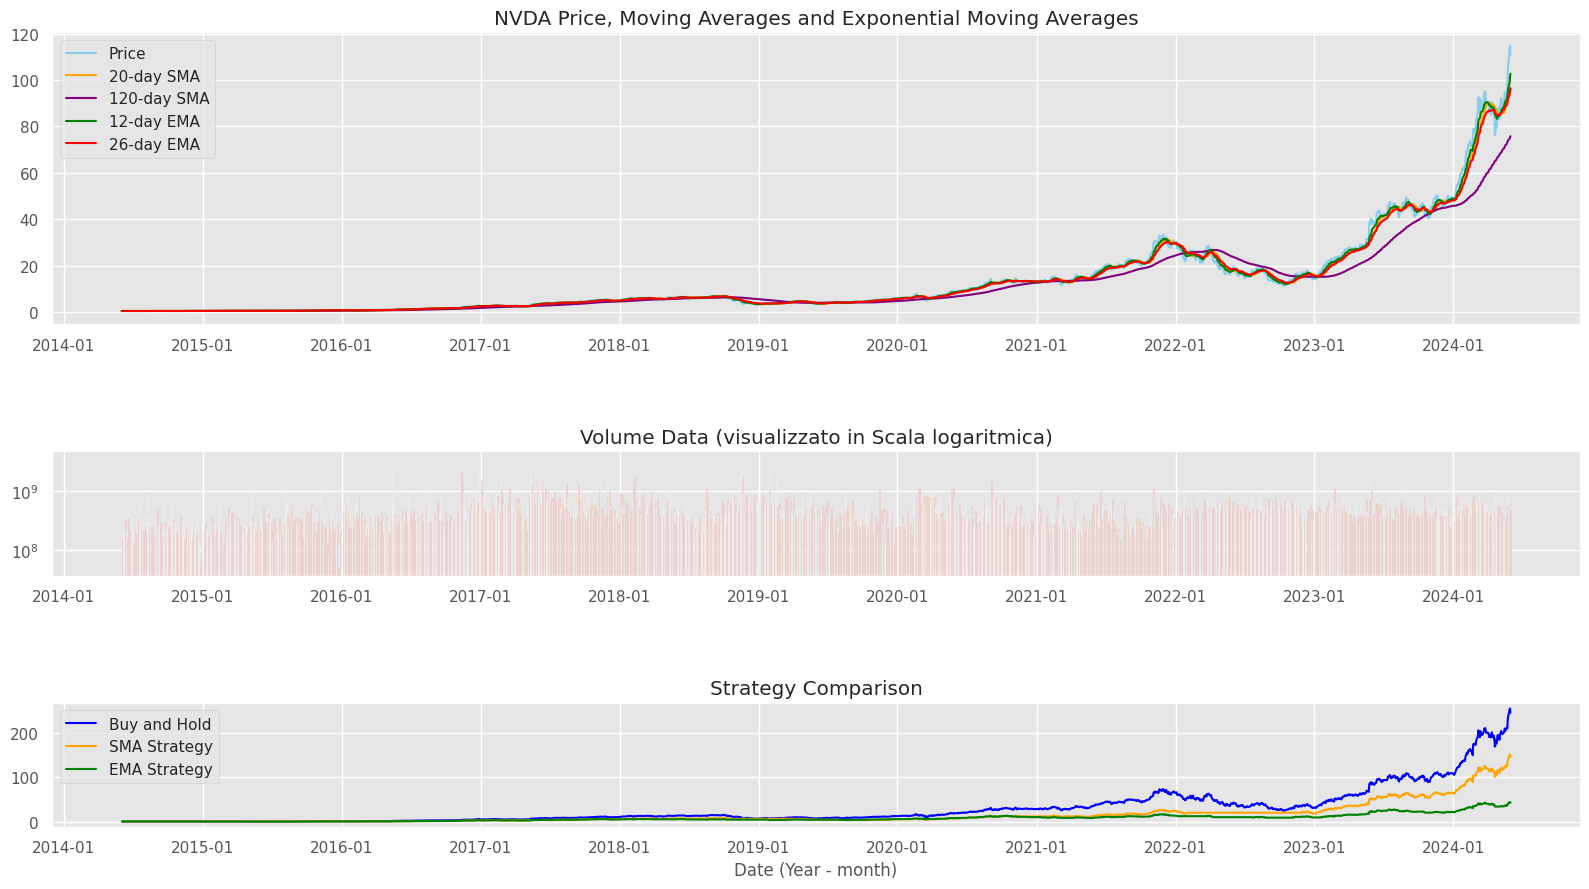

In [55]:
# Iterate through each ticker
style.use('ggplot')
for ticker in tickers:
    data = data_dict[ticker] 
    data['SMA20'] = data['Adj Close'].rolling(window=20).mean() # Simple Moving Average 20
    data['SMA120'] = data['Adj Close'].rolling(window=120).mean() # Simple Moving Average 120
    data['EMA12'] = data['Adj Close'].ewm(span=12, adjust=False).mean() # Exponential Moving Average 12
    data['EMA26'] = data['Adj Close'].ewm(span=26, adjust=False).mean() # Exponential Moving Average 26
    data['Return'] = data['Adj Close'] / data['Adj Close'].shift(1) - 1 # Calcolo dei rendimenti -> 
    data['Cumulative Return'] = (1 + data['Return']).cumprod() # Calcolo dei rendimenti cumulativi -> 
    data['SMA Position'] = (data['SMA20'] > data['SMA120']).astype(int).shift(1) # Calcolo della posizione SMA
    data['SMA Strategy Returns'] = data['Return'] * data['SMA Position'] # Calcolo dei rendimenti della strategia SMA
    data['SMA Cumulative Returns'] = (1 + data['SMA Strategy Returns']).cumprod() # Calcolo dei rendimenti cumulativi della strategia SMA
    data['EMA Position'] = (data['EMA12'] > data['EMA26']).astype(int).shift(1) # Calcolo della posizione EMA
    data['EMA Strategy Returns'] = data['Return'] * data['EMA Position'] # Calcolo dei rendimenti della strategia EMA
    data['EMA Cumulative Returns'] = (1 + data['EMA Strategy Returns']).cumprod() # Calcolo dei rendimenti cumulativi della strategia EMA

    # Setting up the plots
    plt.figure(figsize=(16,9))
    ax1 = plt.subplot2grid((10,1), (0,0), rowspan=4, colspan=1)
    ax2 = plt.subplot2grid((10,1), (5,0), rowspan=2, colspan=1, sharex=ax1)
    ax3 = plt.subplot2grid((10,1), (8,0), rowspan=2, colspan=1, sharex=ax1)

    # Plotting price, SMAs, and EMAs
    ax1.plot(data.index, data['Adj Close'], label='Price', color='skyblue')
    ax1.plot(data.index, data['SMA20'], label='20-day SMA', color='orange')
    ax1.plot(data.index, data['SMA120'], label='120-day SMA', color='purple')
    ax1.plot(data.index, data['EMA12'], label='12-day EMA', color='green')
    ax1.plot(data.index, data['EMA26'], label='26-day EMA', color='red')
    ax1.set_title(f'{ticker} Price, Moving Averages and Exponential Moving Averages')
    ax1.legend()

    # Plotting volume with adjusted bar width
    ax2.bar(data.index, data['Volume'])
    ax2.set_yscale('log')  # Using logarithmic scale
    ax2.set_title('Volume Data (visualizzato in Scala logaritmica)')

    # Plotting strategy comparison
    ax3.plot(data.index, data['Cumulative Return'], label='Buy and Hold', color='blue')
    ax3.plot(data.index, data['SMA Cumulative Returns'], label='SMA Strategy', color='orange')
    ax3.plot(data.index, data['EMA Cumulative Returns'], label='EMA Strategy', color='green')
    ax3.set_title('Strategy Comparison')
    ax3.legend()

    # Formatting the date on the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax3.set_xlabel('Date (Year - month)')

    plt.tight_layout()
    plt.show()


Ticker: AMZN
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


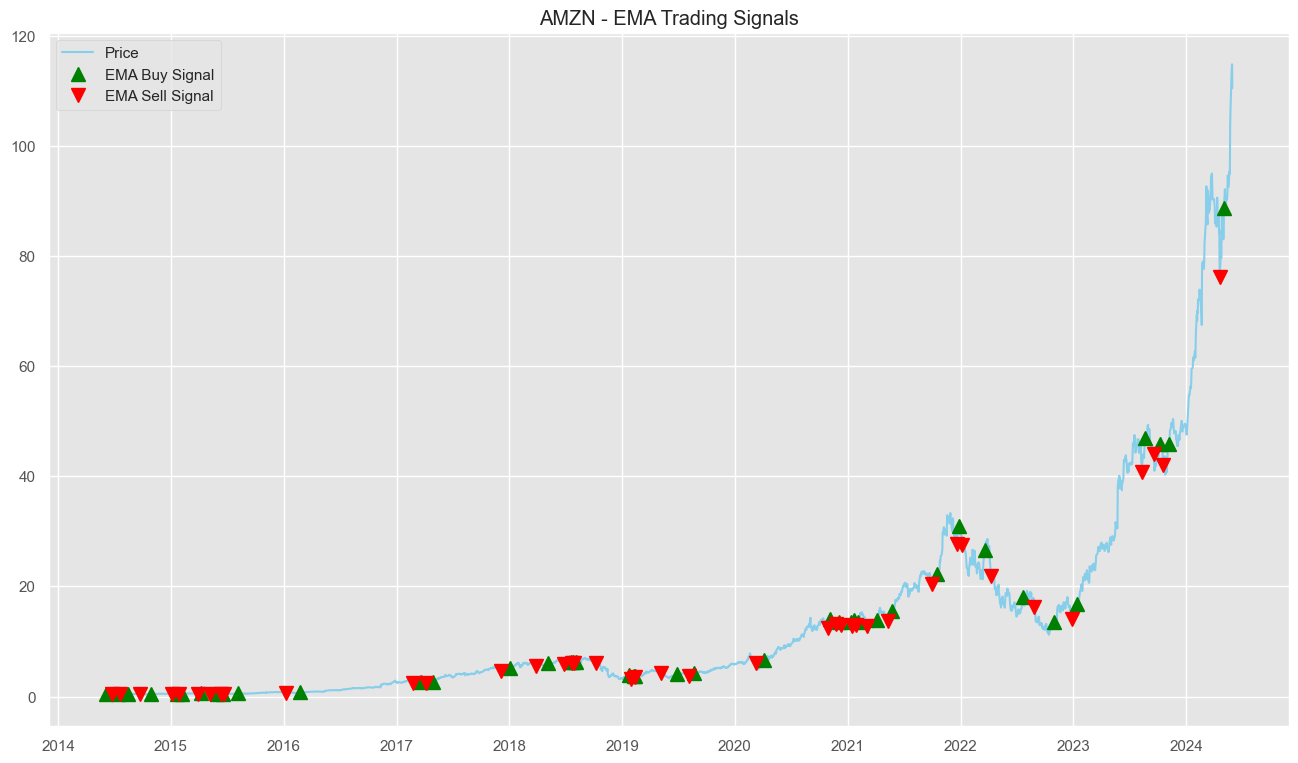

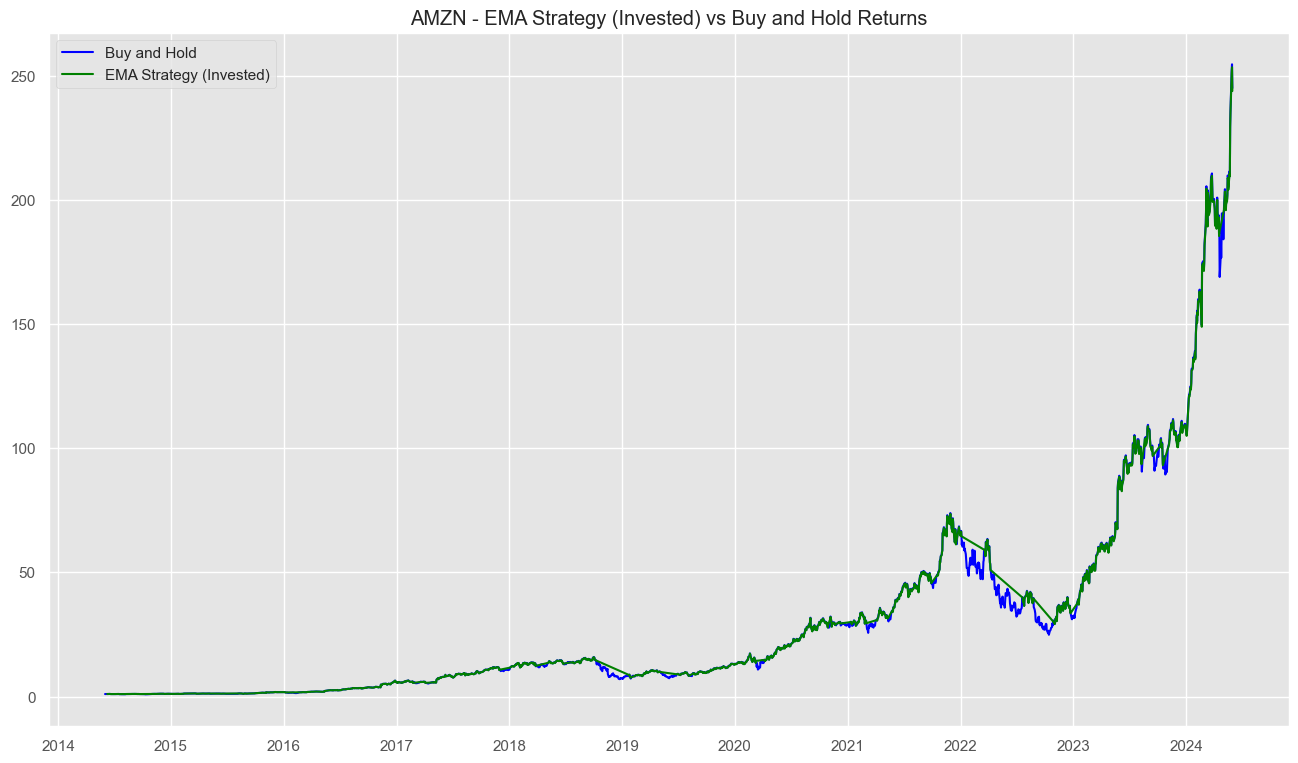

Ticker: MCD
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


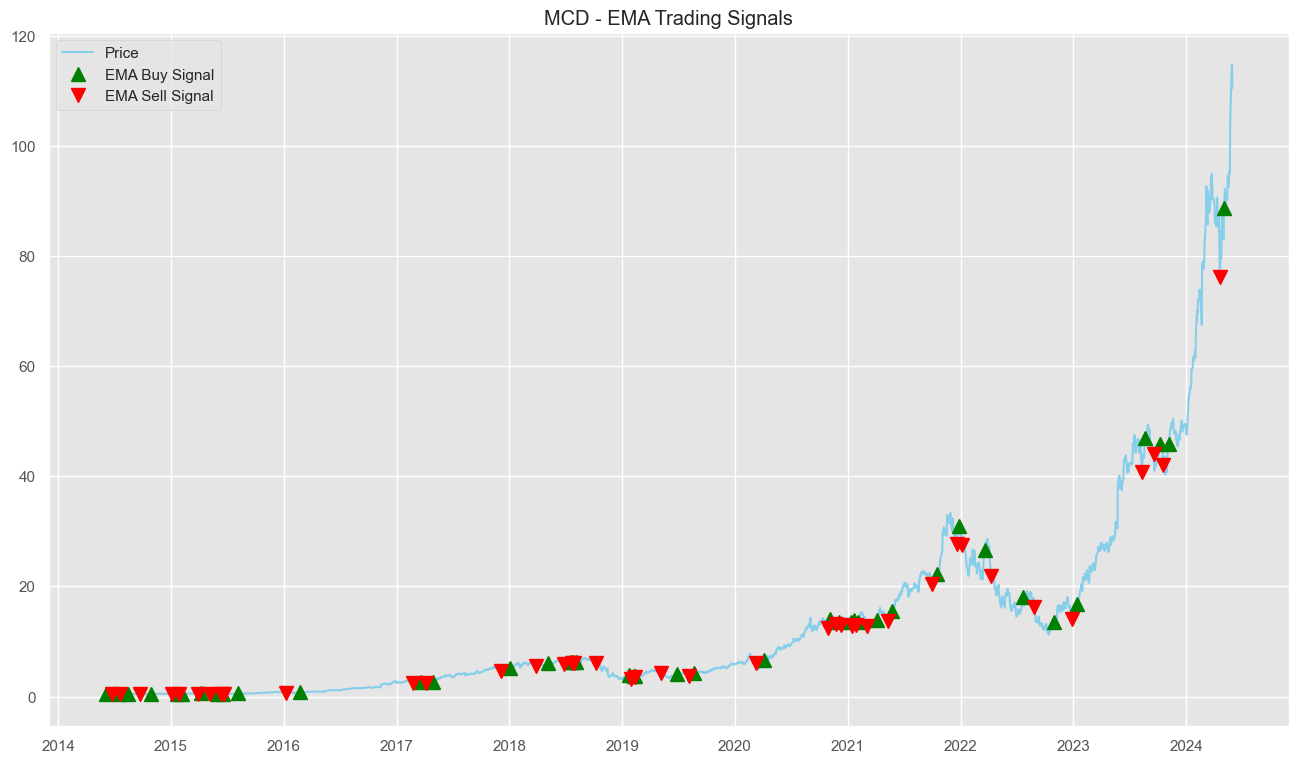

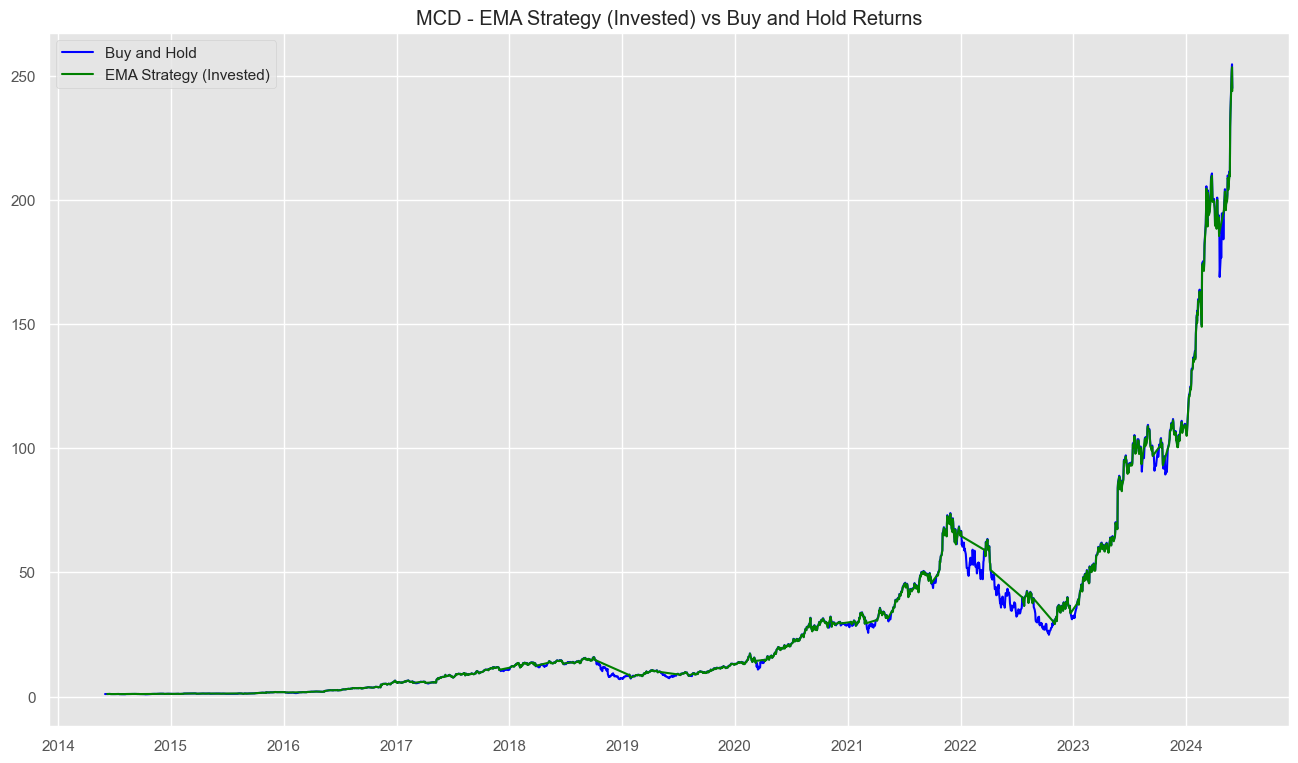

Ticker: PG
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


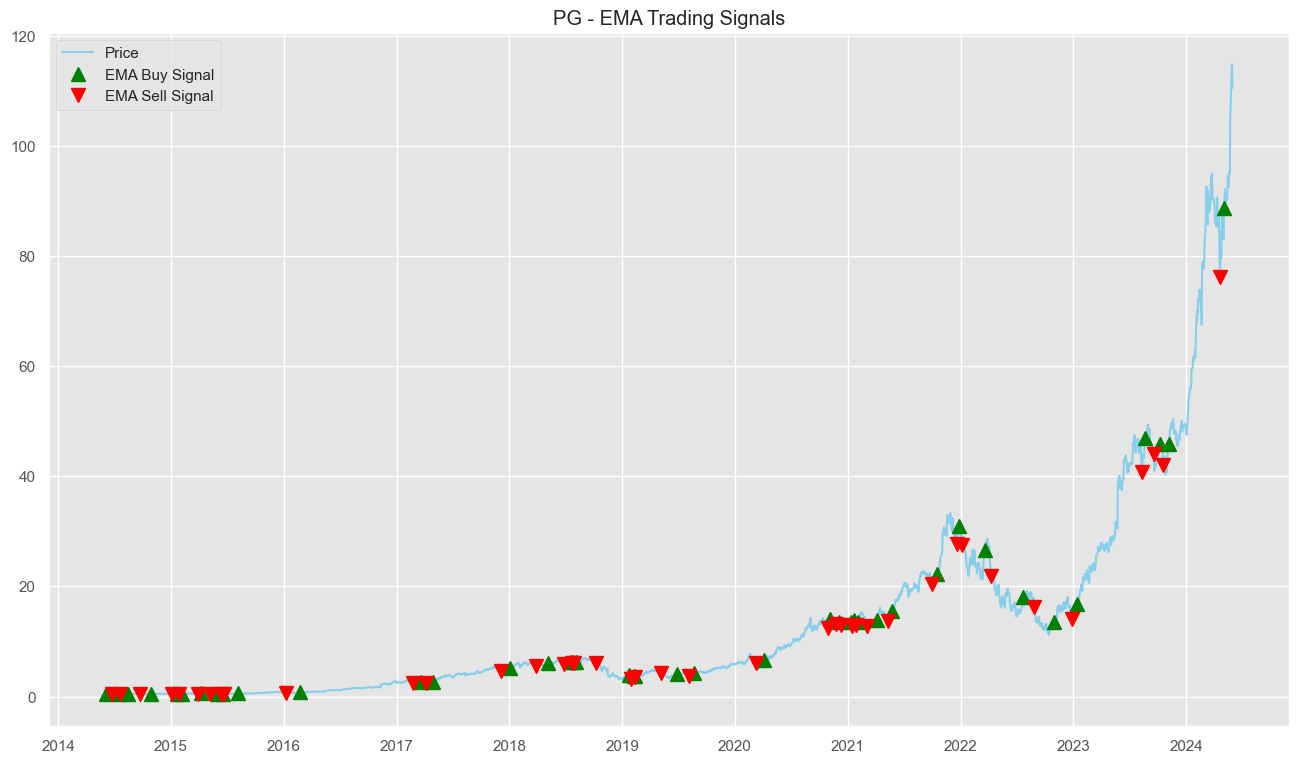

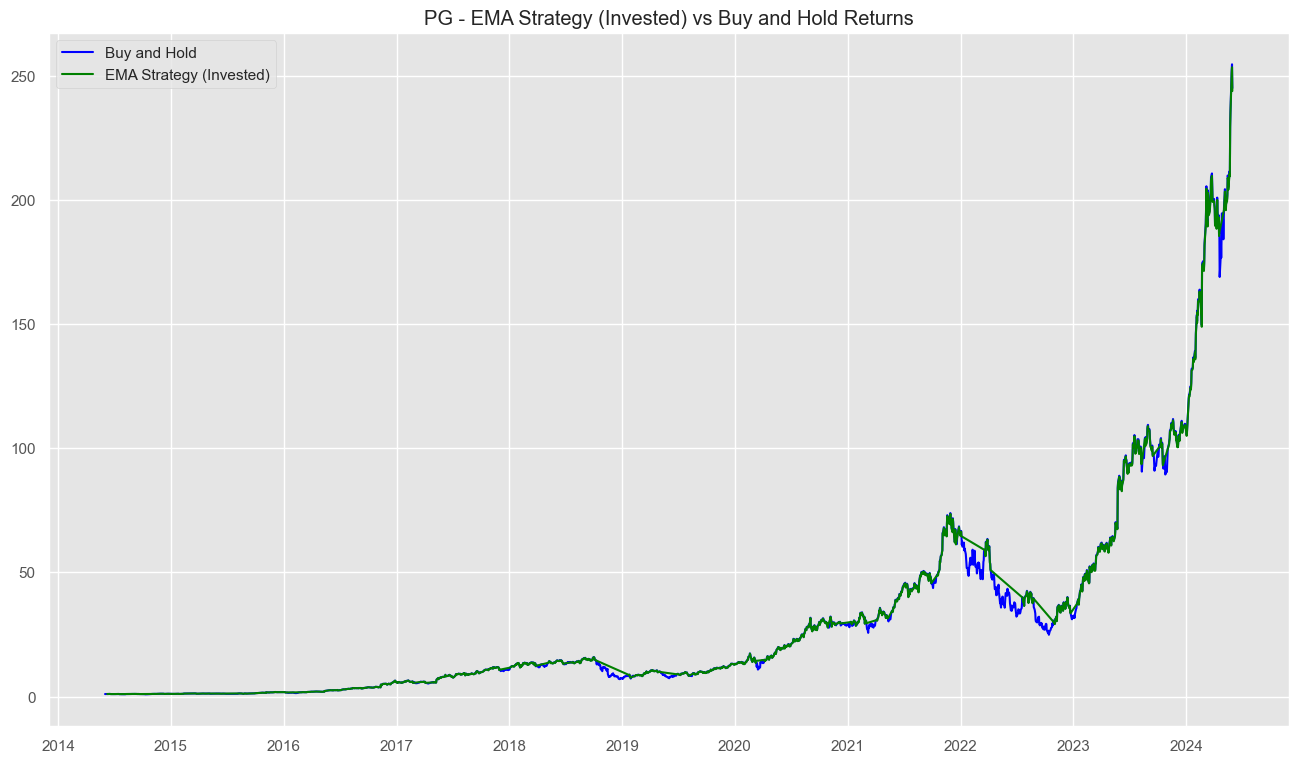

Ticker: WMT
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


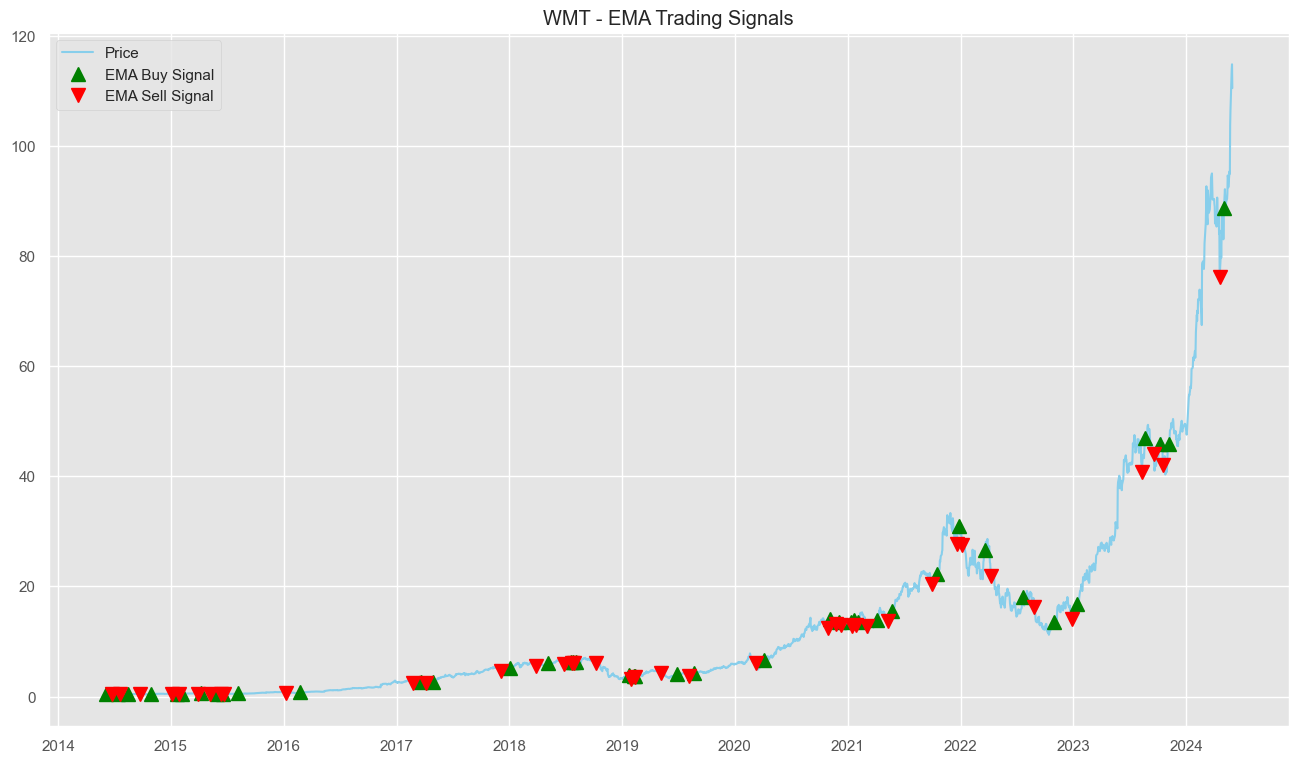

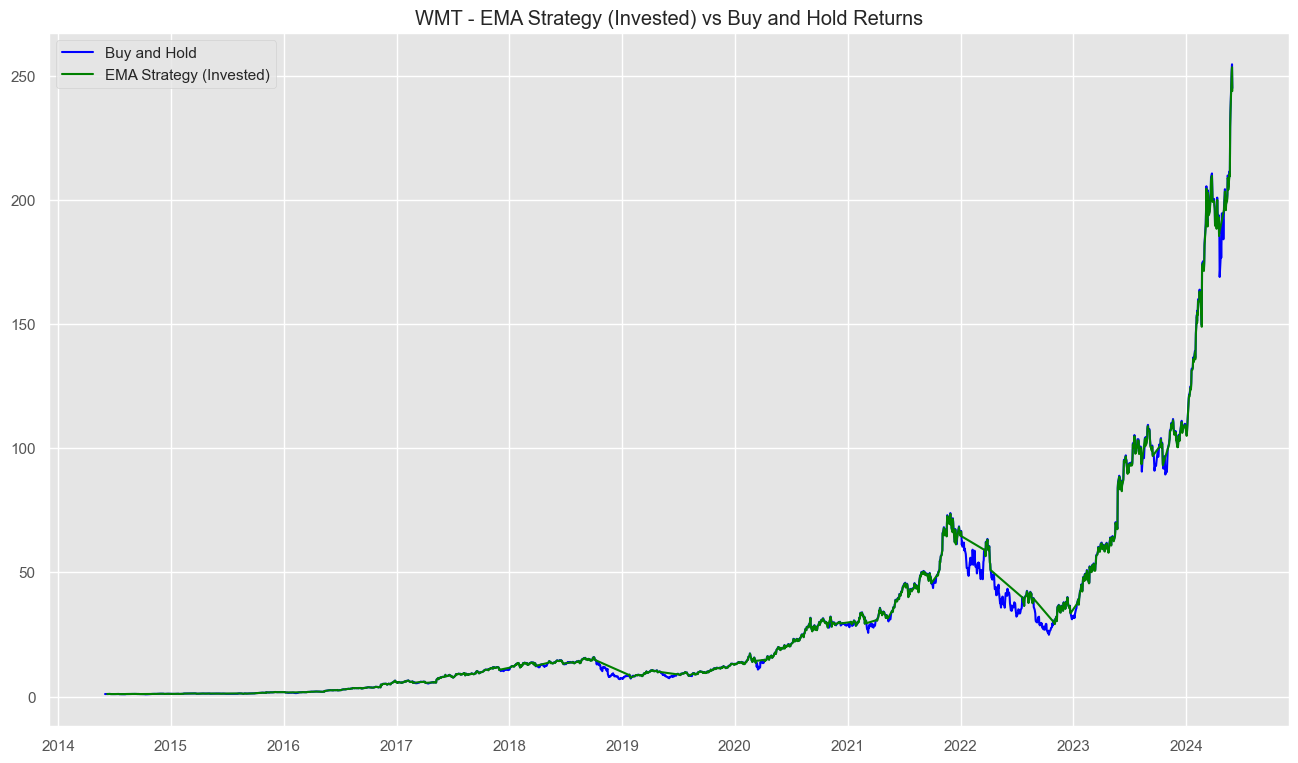

Ticker: AAPL
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


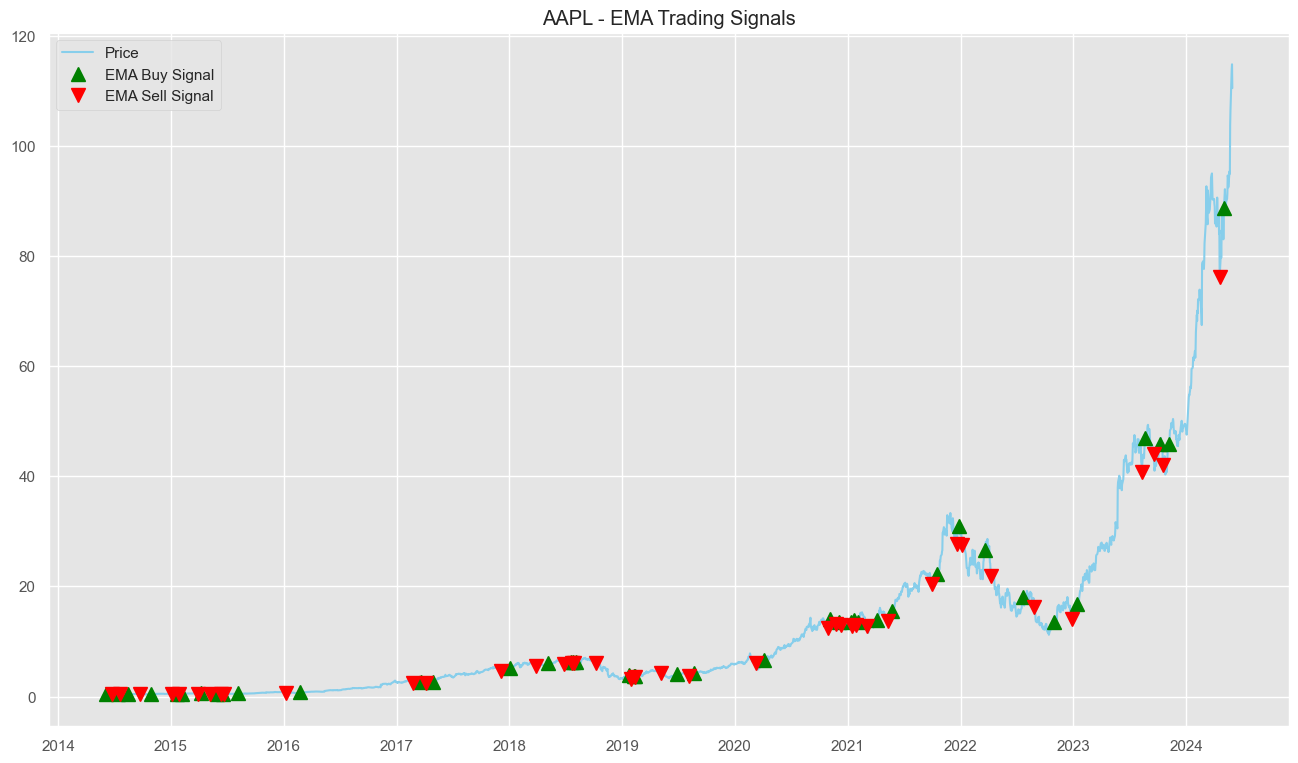

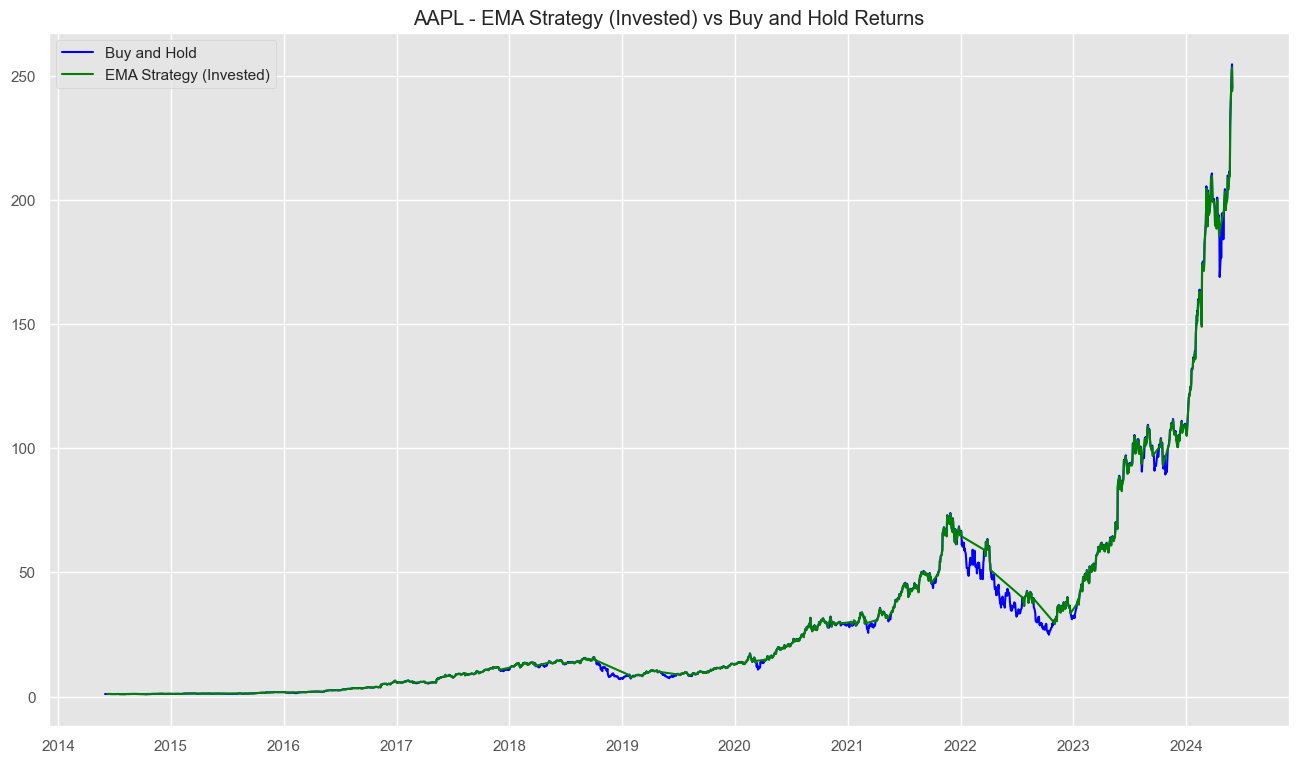

Ticker: NVDA
EMA Buy signals: 41
EMA Sell signals: 40
Days without signals: 2436


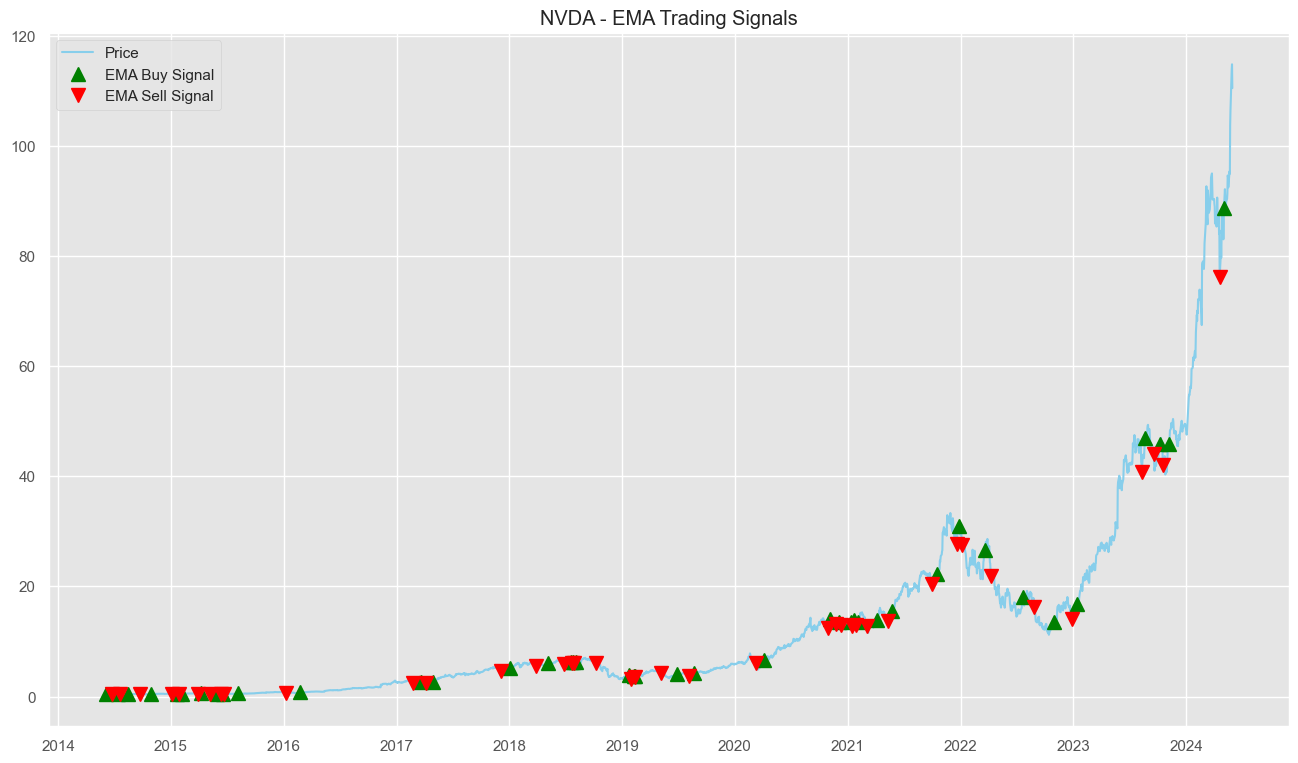

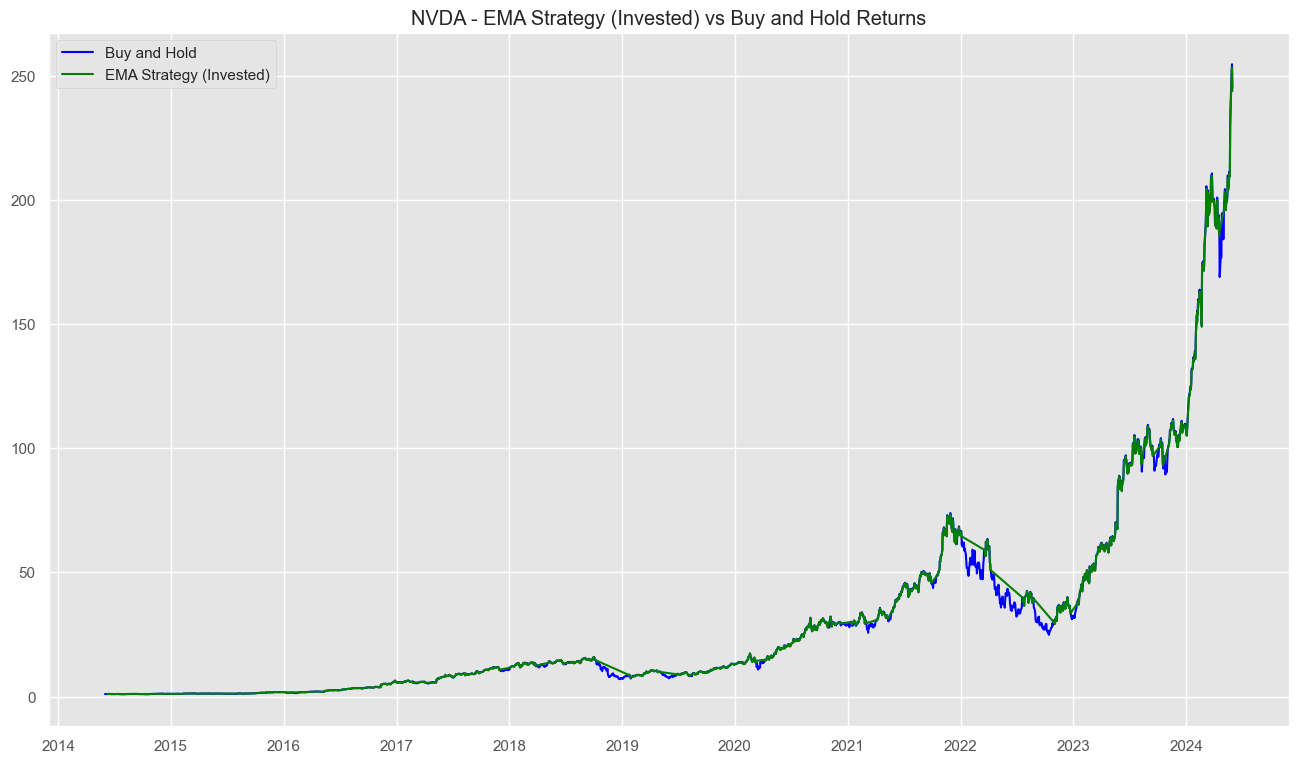

In [ ]:
for ticker in tickers:
    # Calcola le EMA
    data['EMA12'] = data['Adj Close'].ewm(span=12, adjust=False).mean()
    data['EMA26'] = data['Adj Close'].ewm(span=26, adjust=False).mean()

    # Strategia 1: Segnali di acquisto e vendita basati sulle EMA
    data['EMA Buy'] = ((data['EMA12'] > data['EMA26']) & (data['EMA12'].shift(1) < data['EMA26'].shift(1))).astype(int)
    data['EMA Sell'] = ((data['EMA12'] < data['EMA26']) & (data['EMA12'].shift(1) > data['EMA26'].shift(1))).astype(int)

    # Strategia 2: Investimento basato sulla relazione delle EMA
    data['Invested_EWM'] = [1 if data.loc[i, 'EMA12'] > data.loc[i, 'EMA26'] else 0 for i in data.index]
    ewm = data[data['Invested_EWM'] == 1].copy()
    ewm['Price_yesterday'] = ewm['Adj Close'].shift(1)
    ewm['Change'] = ewm['Adj Close'] / ewm['Price_yesterday']
    ewm['Return'] = ewm['Change'].cumprod()

    # Strategia 3: Buy and Hold
    data['Buy_Hold_Return'] = data['Adj Close'] / data['Adj Close'].iloc[0]

    # Conta i segnali per la Strategia 1
    ema_buys = data['EMA Buy'].sum()
    ema_sells = data['EMA Sell'].sum()
    no_signal_days = len(data) - (ema_buys + ema_sells)

    # Output dei conteggi per la Strategia 1
    print(f'Ticker: {ticker}')
    print(f'EMA Buy signals: {ema_buys}')
    print(f'EMA Sell signals: {ema_sells}')
    print(f'Days without signals: {no_signal_days}')

    # Grafico del prezzo e dei segnali per la Strategia 1
    plt.figure(figsize=(16,9))
    plt.plot(data.index, data['Adj Close'], label='Price', color='skyblue')
    plt.plot(data[data['EMA Buy'] == 1].index, data['Adj Close'][data['EMA Buy'] == 1], '^', markersize=10, color='green', label='EMA Buy Signal')
    plt.plot(data[data['EMA Sell'] == 1].index, data['Adj Close'][data['EMA Sell'] == 1], 'v', markersize=10, color='red', label='EMA Sell Signal')
    plt.title(f'{ticker} - EMA Trading Signals')
    plt.legend()
    plt.show()

    # Grafico dei ritorni cumulativi per la strategia EMA (Invested) e Buy and Hold
    plt.figure(figsize=(16,9))
    plt.plot(data.index, data['Buy_Hold_Return'], label='Buy and Hold', color='blue')
    plt.plot(ewm.index, ewm['Return'], label='EMA Strategy (Invested)', color='green')
    plt.title(f'{ticker} - EMA Strategy (Invested) vs Buy and Hold Returns')
    plt.legend()
    plt.show()


Nell'esempio che ti ho fornito, la strategia di trading è basata sull'uso delle medie mobili esponenziali (EMA). Questa è una strategia molto popolare nei mercati finanziari per via della sua semplicità e efficienza. Ecco come funziona la strategia applicata:

Medie Mobili Esponenziali (EMA)
Le medie mobili esponenziali sono una forma di media mobile che dà più peso ai prezzi più recenti. L'EMA reagisce più velocemente alle variazioni di prezzo rispetto alla media mobile semplice (SMA), rendendola particolarmente utile in mercati volatili.

Strategia di Incrocio delle EMA
La strategia utilizzata è quella dell'incrocio delle EMA (conosciuta anche come "crossover"). In questa strategia, si utilizzano due linee di EMA:

EMA a breve termine (12 giorni nel nostro caso): Questa linea segue più da vicino l'andamento del prezzo perché è sensibile alle recenti variazioni di prezzo.
EMA a lungo termine (26 giorni nel nostro caso): Questa linea è più liscia e meno reattiva alle fluttuazioni giornaliere del prezzo.
Segnali di Acquisto e Vendita
I segnali sono generati sulla base dell'incrocio di queste due EMA:

Segnale di acquisto: Viene generato quando l'EMA a breve termine incrocia al rialzo l'EMA a lungo termine. Questo è interpretato come un segnale che il trend di breve termine sta diventando più forte rispetto al trend di lungo termine, suggerendo un potenziale inizio di un trend rialzista.
Segnale di vendita: Viene generato quando l'EMA a breve termine incrocia al ribasso l'EMA a lungo termine. Questo è visto come un segnale che il trend di breve termine sta indebolendosi rispetto a quello di lungo termine, indicando la possibile fine di un trend rialzista o l'inizio di un trend ribassista.
Applicazione Pratica
Nel codice che ho descritto, vengono visualizzati graficamente sia i prezzi di chiusura regolati (Adj Close) che le due EMA. Vengono poi aggiunti i marker nei punti in cui si verificano gli incroci delle EMA, fornendo segnali visivi di quando entrare o uscire dal mercato secondo la strategia. Questo approccio visivo aiuta gli investitori a capire rapidamente quando la strategia suggerisce di modificare la posizione, basandosi su criteri tecnici piuttosto che emotivi o speculativi.

Questa strategia è ampiamente utilizzata sia dai trader retail che istituzionali e può essere implementata su diverse scale temporali, da quelle intraday a quelle più lunghe, a seconda delle esigenze e degli stili di trading dell'investitore.

# 5. CAPM

In [82]:
market_returns = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close'].resample('M').ffill().pct_change()

[*********************100%%**********************]  1 of 1 completed


In [83]:
betas = {}
monthly_returns = {}
stock_returns = adjusted_close_df.resample('M').ffill().pct_change() # Calcola i rendimenti mensili di ogni ticker

In [84]:
def calculate_beta(asset_returns, market_returns):
    """Calcola il beta di un asset rispetto al mercato."""
    df = pd.DataFrame({
        'asset': asset_returns,
        'market': market_returns
    })
    covariance = df.cov().loc['asset', 'market']
    variance_market = df['market'].var()
    return covariance / variance_market

In [85]:
for ticker in tickers:
    monthly_return_asset = stock_returns[ticker]
    beta = calculate_beta(monthly_return_asset, market_returns)
    
    betas[ticker] = beta
    monthly_returns[ticker] = monthly_return_asset

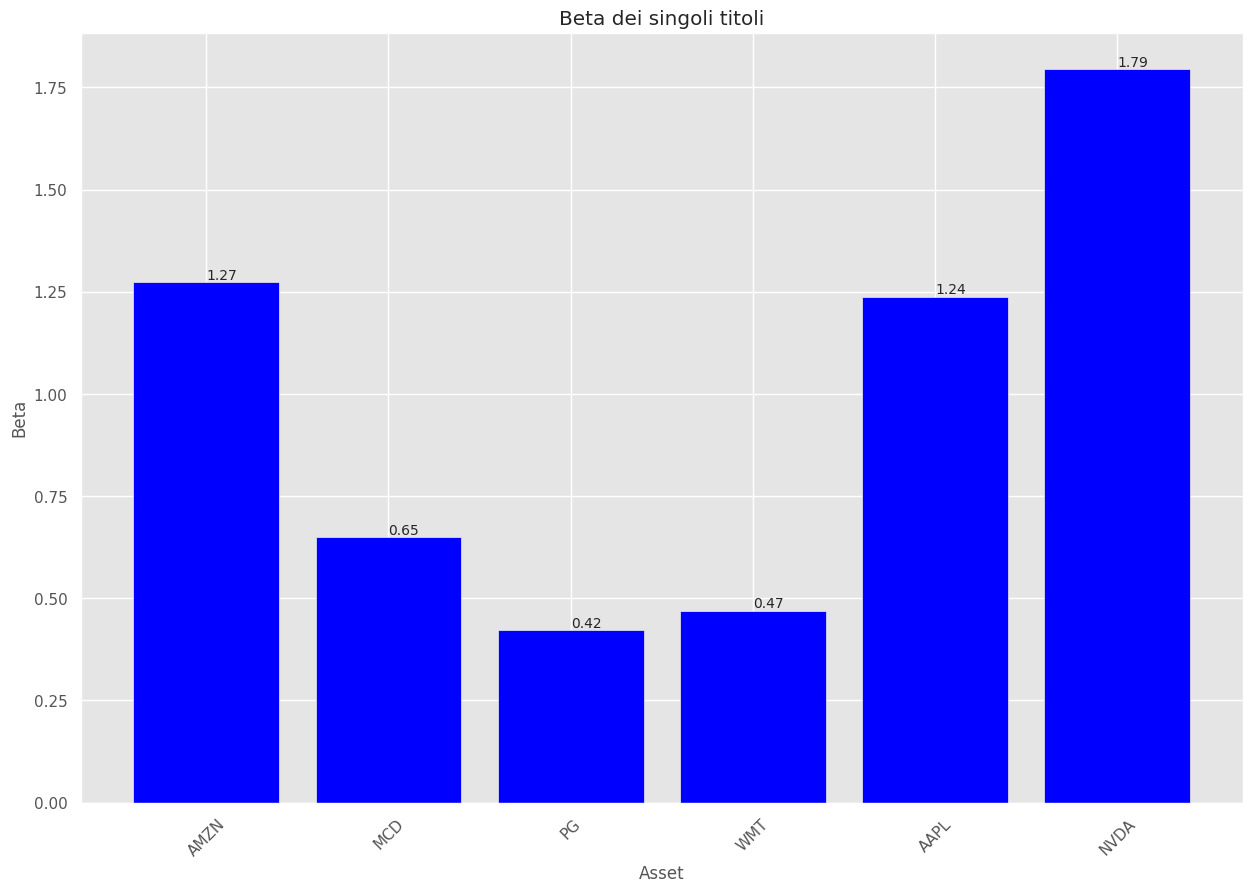

In [87]:
# Plot dei beta dei singoli titoli
plt.figure(figsize=(15, 10))
bars = plt.bar(betas.keys(), betas.values(), color='blue')
plt.xlabel('Asset')
plt.ylabel('Beta')
plt.title('Beta dei singoli titoli')
plt.xticks(rotation=45)

# Aggiungere le etichette dei valori di beta sopra le barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')  # Modifica va da 'bottom' a 'top' se necessario

plt.show()

In [78]:
# Scaricare i dati dell'S&P 500 e dei T-Bill a 1 anno
sp500 = yf.download('^GSPC', start=start_date, end=end_date)['Adj Close']
tbill = yf.download('^IRX', start='2010-01-01', end='2024-01-01')['Adj Close'] / 100  # Rendimenti dei T-Bill

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [76]:
# Calcolare i rendimenti mensili
sp500_returns = sp500.resample('M').last().pct_change().dropna()
tbill_returns = tbill.resample('M').last().dropna()

In [77]:
# Ottimizzazione dei parametri
sp500_params = arima_grid_search(sp500_returns, 12)
tbill_params = arima_grid_search(tbill_returns, 12)
print(f"Parametri ottimizzati per S&P 500: {sp500_params}", f"Parametri ottimizzati per T-Bill: {tbill_params}", sep='\n')

Parametri ottimizzati per S&P 500: (-570.0370025540692, (0, 0, 1), (1, 0, 1, 12))
Parametri ottimizzati per T-Bill: (-1715.1457025075717, (1, 1, 1), (0, 0, 0, 12))


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.68240D+00    |proj g|=  4.93887D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     18      1     0     0   4.939D-03  -1.682D+00
  F =  -1.6823999909294269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.1

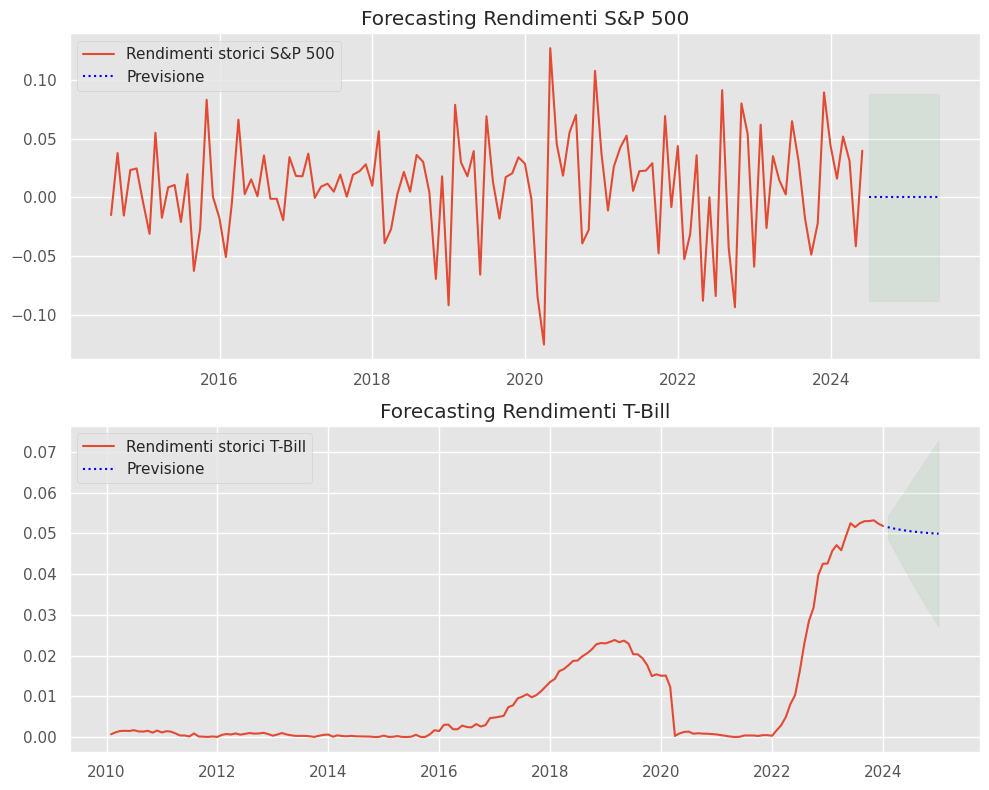

In [71]:
# Modello ARIMA per il forecasting con parametri ottimizzati
def forecast_returns(data, params, steps=12):
    model = SARIMAX(data, order=params[1], seasonal_order=params[2])
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    conf_int = model_fit.get_forecast(steps=steps).conf_int()
    return forecast, conf_int

# Previsione dei rendimenti
sp500_forecast, sp500_conf_int = forecast_returns(sp500_returns, sp500_params)
tbill_forecast, tbill_conf_int = forecast_returns(tbill_returns, tbill_params)

# Prendere l'ultimo valore previsto come stima
R_m_forecast = sp500_forecast.iloc[-1]
R_f_forecast = tbill_forecast.iloc[-1]

print(f"Rendimento atteso del mercato (R_m): {R_m_forecast * 100:.2f}%")
print(f"Rendimento privo di rischio (R_f): {R_f_forecast * 100:.2f}%")

# Visualizzare i risultati del forecasting
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# S&P 500 Forecasting
axs[0].plot(sp500_returns.index, sp500_returns, label='Rendimenti storici S&P 500')
axs[0].plot(sp500_forecast.index, sp500_forecast, color='blue', linestyle='dotted', label='Previsione')
axs[0].fill_between(sp500_forecast.index, sp500_conf_int.iloc[:, 0], sp500_conf_int.iloc[:, 1], color='g', alpha=0.1)
axs[0].set_title('Forecasting Rendimenti S&P 500')
axs[0].legend()

# T-Bill Forecasting
axs[1].plot(tbill_returns.index, tbill_returns, label='Rendimenti storici T-Bill')
axs[1].plot(tbill_forecast.index, tbill_forecast, color='blue', linestyle='dotted', label='Previsione')
axs[1].fill_between(tbill_forecast.index, tbill_conf_int.iloc[:, 0], tbill_conf_int.iloc[:, 1], color='g', alpha=0.1)
axs[1].set_title('Forecasting Rendimenti T-Bill')
axs[1].legend()

plt.tight_layout()
plt.show()


Rendimenti attesi per i titoli:
AMZN: 0.0936254731732004
MCD: 0.06244907284309353
PG: 0.051092084591919704
WMT: 0.0535076172186021
AAPL: 0.09188670435325745
NVDA: 0.12028936114294128


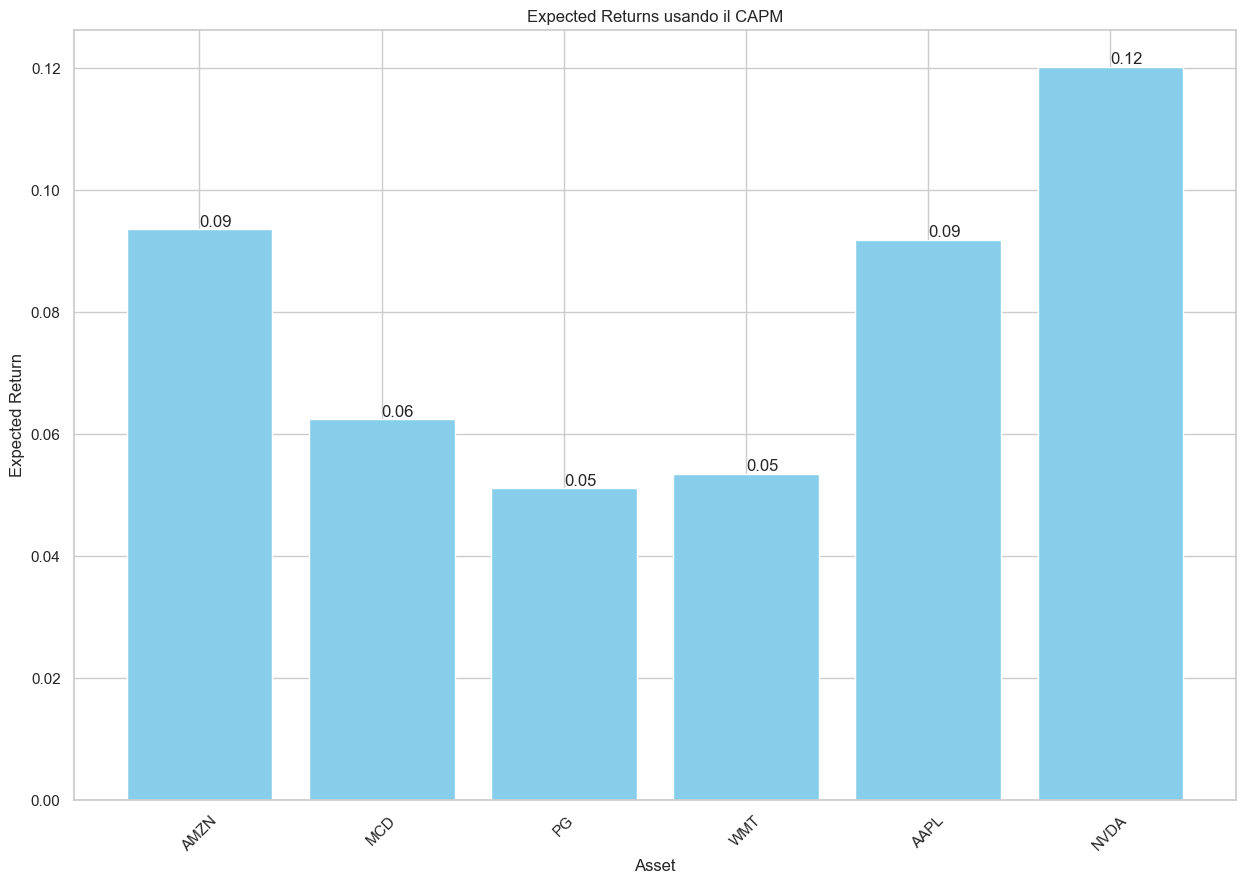

In [ ]:
# Calcolare i rendimenti attesi utilizzando il CAPM
expected_returns = {}
for ticker, beta in betas.items():
    expected_return = R_f_forecast + beta * (R_m_forecast - R_f_forecast)
    expected_returns[ticker] = expected_return

# Mostrare i rendimenti attesi
print("\nRendimenti attesi per i titoli:")
for ticker, exp_return in expected_returns.items():
    print(f"{ticker}: {exp_return}")

# Plot dei rendimenti attesi dei singoli titoli
plt.figure(figsize=(15, 10))
bars = plt.bar(expected_returns.keys(), expected_returns.values(), color='skyblue')
plt.xlabel('Asset')
plt.ylabel('Expected Return')
plt.title('Expected Returns usando il CAPM')
plt.xticks(rotation=45)

# Aggiungere le etichette dei valori di rendimento atteso sopra le barre
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

plt.show()

[*********************100%%**********************]  6 of 6 completed


            AAPL      AMZN       MCD      NVDA        PG       WMT
const   0.018516  0.017367  0.012931  0.044091  0.009655  0.009275
Mkt-RF  0.280601 -0.201632  0.656103  1.870216  1.267274  1.065210
SMB    -3.541467 -3.177190 -1.868133 -1.183975 -0.479490 -0.752261
HML    -1.624479 -1.843606 -0.461793 -0.023752 -0.793098 -0.748101


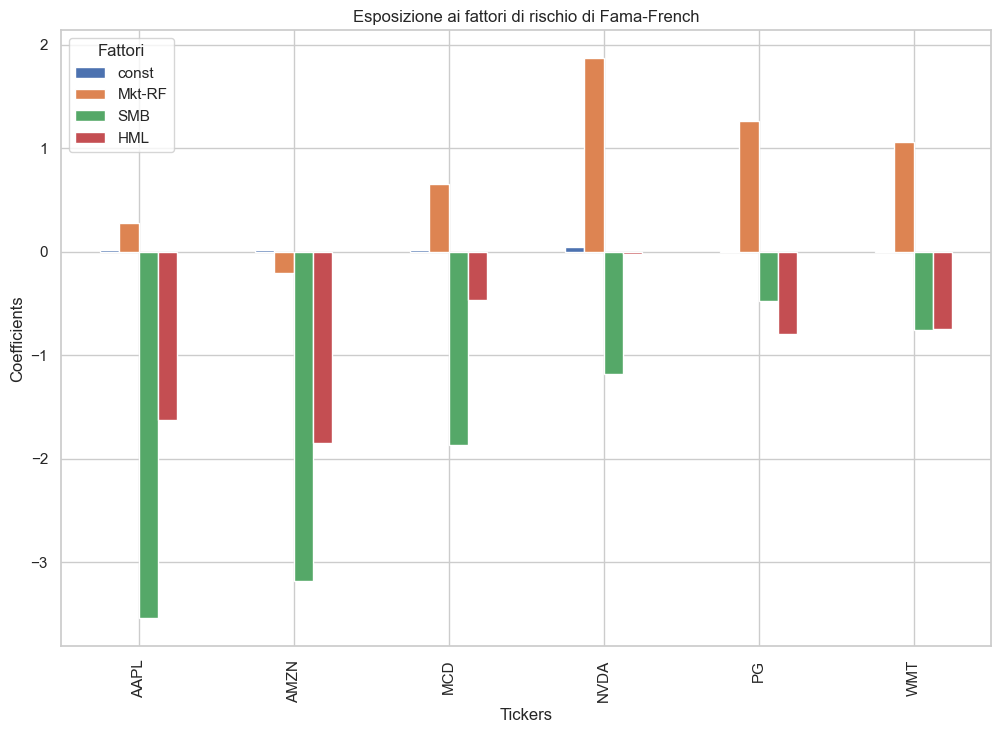

In [ ]:
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from io import BytesIO
from zipfile import ZipFile
import requests

# Funzione per scaricare e pulire i dati dei fattori di Fama-French
def get_fama_french_factors():
    url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip'
    response = requests.get(url)
    with ZipFile(BytesIO(response.content)) as z:
        with z.open('F-F_Research_Data_Factors_daily.CSV') as f:
            fama_french_factors = pd.read_csv(f, skiprows=3, index_col=0)
    
    # Rimuovi eventuali righe non necessarie
    fama_french_factors = fama_french_factors[~fama_french_factors.index.str.contains('Copyright')]
    
    # Converti l'indice in formato datetime
    fama_french_factors.index = pd.to_datetime(fama_french_factors.index, format='%Y%m%d')
    fama_french_factors = fama_french_factors[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100  # Converti i valori in percentuale
    return fama_french_factors

# Scarica i dati dei fattori di Fama-French
fama_french_factors = get_fama_french_factors()

# Converti i dati in base mensile
fama_french_factors = fama_french_factors.resample('M').last()

# Filtra l'intervallo richiesto
fama_french_factors = fama_french_factors['2012-11-30':'2022-11-30']

# Scarica i dati dei titoli da Yahoo Finance
tickers = ["AMZN", "MCD", "PG", "WMT", "AAPL", "NVDA"]
data = yf.download(tickers, start='2012-11-01', end='2022-12-01')['Adj Close']

# Calcola i rendimenti mensili
returns = data.resample('M').last().pct_change().dropna()

# Allinea i dati dei fattori di Fama-French con i dati dei rendimenti
factor_df = fama_french_factors.loc[returns.index]

# Calcola l'excess return dei titoli
excess_returns = returns.subtract(factor_df['RF'].values, axis=0)

# Funzione per calcolare l'esposizione ai fattori di rischio di Fama-French
def calculate_exposure(excess_returns, factor_df):
    exposures = {}
    for ticker in excess_returns.columns:
        y = excess_returns[ticker]
        X = factor_df[['Mkt-RF', 'SMB', 'HML']]
        X = sm.add_constant(X)  # Aggiungi l'intercetta
        model = sm.OLS(y, X).fit()
        exposures[ticker] = model.params
    return pd.DataFrame(exposures)

# Calcola l'esposizione ai fattori di rischio di Fama-French
exposures = calculate_exposure(excess_returns, factor_df)
print(exposures)

# Visualizza i risultati
exposures.T.plot(kind='bar', figsize=(12, 8))
plt.title('Esposizione ai fattori di rischio di Fama-French')
plt.ylabel('Coefficients')
plt.xlabel('Tickers')
plt.legend(title='Fattori')
plt.show()


# 6. Costruzione di portafoglio

[*********************100%%**********************]  6 of 6 completed


Optimal Weights (Analytic): [0.00000000e+00 3.60822483e-16 0.00000000e+00 1.00000000e+00
 0.00000000e+00 0.00000000e+00]
Optimal Weight for WMT: 1.0


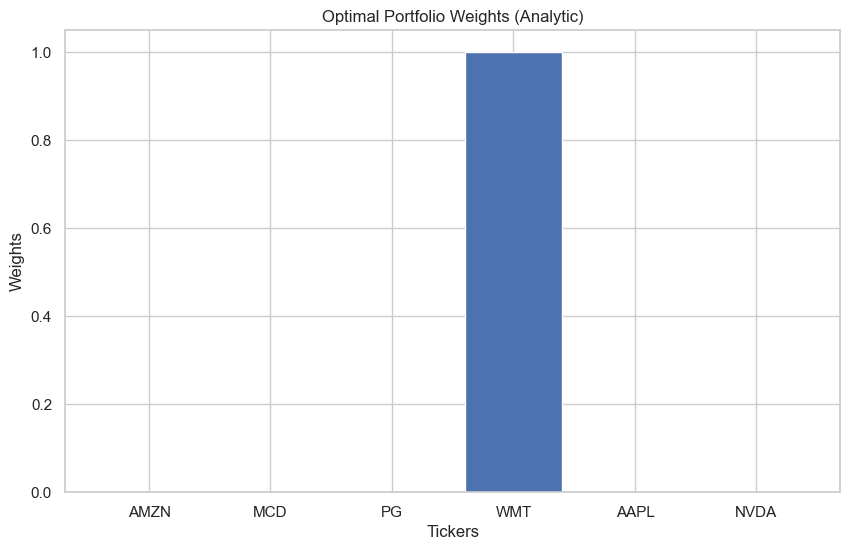

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Scarica i dati dei titoli da Yahoo Finance
tickers = ["AMZN", "MCD", "PG", "WMT", "AAPL", "NVDA"]
data = yf.download(tickers, start='2012-11-01', end='2022-12-01')['Adj Close']

# Calcola i rendimenti mensili
returns = data.resample('M').last().pct_change().dropna()

# Utilizza i primi 108 mesi di dati
returns = returns.iloc[:108]

# Funzione per calcolare i rendimenti e la matrice di covarianza
def get_statistics(returns):
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    return mean_returns, cov_matrix

mean_returns, cov_matrix = get_statistics(returns) # Ho già la matrice di covarianza

# Funzione per calcolare il portafoglio ottimale
def portfolio_optimization(mean_returns, cov_matrix, risk_free_rate=0.0):
    num_assets = len(mean_returns)
    
    def portfolio_variance(weights):
        return weights.T @ cov_matrix @ weights
    
    def portfolio_return(weights):
        return np.sum(mean_returns * weights)
    
    def objective_function(weights):
        return portfolio_variance(weights) - portfolio_return(weights)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1. / num_assets]
    
    result = minimize(objective_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

opt_result = portfolio_optimization(mean_returns, cov_matrix)
optimal_weights_analytic = opt_result.x

print(f"Optimal Weights (Analytic): {optimal_weights_analytic}")

# Estrai il peso ottimale di WMT
wmt_weight = optimal_weights_analytic[tickers.index('WMT')]
print(f"Optimal Weight for WMT: {wmt_weight}")

# Visualizzazione dei pesi ottimali
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights_analytic)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights (Analytic)')
plt.show()


Optimal Weights (Simulation): [0.00399913 0.15285663 0.24868858 0.25066833 0.29735205 0.04643527]


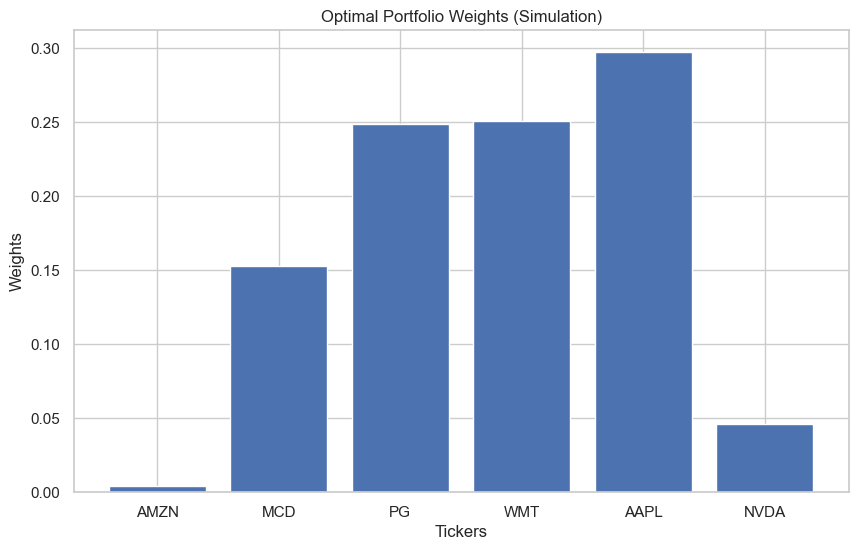

In [ ]:
# Numero di portafogli da simulare
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = results[0,i] / results[1,i]  # Sharpe ratio

max_sharpe_idx = np.argmax(results[2])
optimal_weights_simulation = weights_record[max_sharpe_idx]

print(f"Optimal Weights (Simulation): {optimal_weights_simulation}")

# Visualizzazione dei pesi ottimali
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights_simulation)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights (Simulation)')
plt.show()


Optimal Weights (Simulation): [0.00726874 0.16623897 0.23272659 0.28092928 0.29465729 0.01817913]


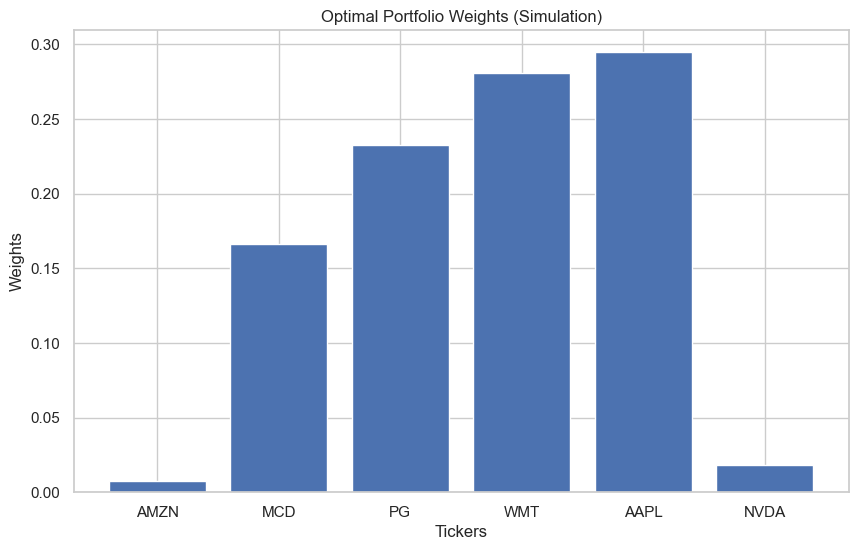

In [ ]:
# Numero di portafogli da simulare
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return = np.sum(mean_returns * weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    results[0,i] = portfolio_return
    results[1,i] = portfolio_stddev
    results[2,i] = results[0,i] / results[1,i]  # Sharpe ratio

max_sharpe_idx = np.argmax(results[2])
optimal_weights_simulation = weights_record[max_sharpe_idx]

print(f"Optimal Weights (Simulation): {optimal_weights_simulation}")

# Visualizzazione dei pesi ottimali
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights_simulation)
plt.xlabel('Tickers')
plt.ylabel('Weights')
plt.title('Optimal Portfolio Weights (Simulation)')
plt.show()


In [ ]:
# Scarica i dati del mercato (S&P 500)
sp500 = yf.download('^GSPC', start='2012-11-01', end='2022-12-01')['Adj Close']
sp500_returns = sp500.resample('M').last().pct_change().dropna()
sp500_returns = sp500_returns.iloc[:108]

# Funzione per calcolare il beta del portafoglio
def calculate_portfolio_beta(returns, market_returns, weights):
    cov_matrix = returns.cov()
    cov_with_market = cov_matrix.dot(market_returns.cov())
    portfolio_beta = np.sum(weights * cov_with_market / market_returns.var())
    return portfolio_beta

portfolio_beta_analytic = calculate_portfolio_beta(returns, sp500_returns, optimal_weights_analytic)
portfolio_beta_simulation = calculate_portfolio_beta(returns, sp500_returns, optimal_weights_simulation)

print(f"Portfolio Beta (Analytic): {portfolio_beta_analytic}")
print(f"Portfolio Beta (Simulation): {portfolio_beta_simulation}")


[*********************100%%**********************]  1 of 1 completed


TypeError: cov() missing 1 required positional argument: 'other'

In [ ]:
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

AMZN RS_Lordo  AMZN RS_Netto       AMZN RL  MCD RS_Lordo  \
weights        0.07167   1.259765e-10  1.256175e-10      0.296167   

         MCD RS_Netto        MCD RL  PG RS_Lordo   PG RS_Netto         PG RL  \
weights  1.247735e-10  1.245719e-10     0.375361  1.246008e-10  1.246815e-10   

         WMT RS_Lordo  WMT RS_Netto        WMT RL  AAPL RS_Lordo  \
weights      0.256802  1.246943e-10  1.247364e-10   8.695519e-09   

         AAPL RS_Netto       AAPL RL  NVDA RS_Lordo  NVDA RS_Netto  \
weights   1.259991e-10  1.258232e-10   6.561549e-10   1.060949e-10   

              NVDA RL  
weights  1.054874e-10

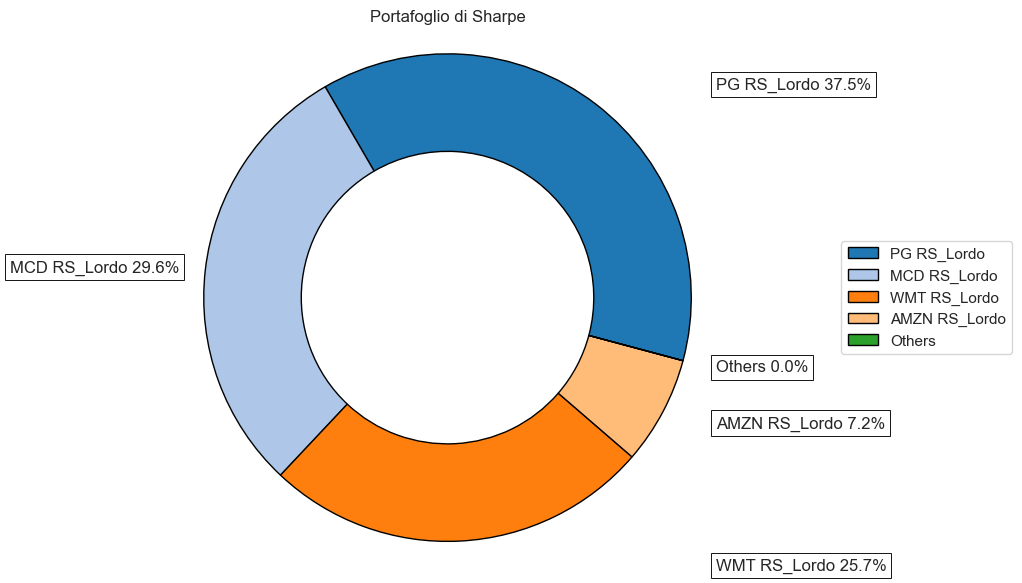

In [ ]:
ax = rp.plot_pie(w=w, title='Portafoglio di Sharpe', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

In [ ]:
points = 50

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

display(frontier.T.head())

AMZN RS_Lordo  AMZN RS_Netto       AMZN RL  MCD RS_Lordo  MCD RS_Netto  \
0       0.035824   3.582375e-02  1.358298e-07      0.147294  1.472943e-01   
1       0.086971   4.913576e-10  4.946732e-10      0.259848  4.761177e-10   
2       0.088173   6.511812e-11  6.540630e-11      0.243623  6.383610e-11   
3       0.089156   6.008877e-11  6.014396e-11      0.230688  5.991979e-11   
4       0.089968   5.273499e-10  5.277021e-10      0.219436  5.264358e-10   

         MCD RL   PG RS_Lordo   PG RS_Netto         PG RL  WMT RS_Lordo  \
0  2.270260e-07  8.572522e-07  8.572522e-07  3.770236e-01      0.009064   
1  4.783946e-10  3.214573e-01  4.736383e-10  4.746144e-10      0.243055   
2  6.403177e-11  3.003599e-01  6.362869e-11  6.371342e-11      0.237388   
3  5.995264e-11  2.835296e-01  5.989341e-11  5.990962e-11      0.232870   
4  5.266377e-10  2.688862e-01  5.262989e-10  5.264023e-10      0.228921   

   WMT RS_Netto        WMT RL  AAPL RS_Lordo  AAPL RS_Netto       AAPL RL  \
0  9.064188e-03  2.386096e-01   1.090471e-07   1.090471e-07  7.552301e-08   
1  4.796930e-10  4.808966e-10   1.591720e-02   4.956190e-10  4.987509e-10   
2  6.414324e-11  6.424790e-11   1.584467e-02   6.547962e-11  6.575051e-11   
3  5.996542e-11  5.998582e-11   1.577647e-02   6.014027e-11  6.018926e-11   
4  5.267200e-10  5.268505e-10   1.576245e-02   5.276737e-10  5.279820e-10   

   NVDA RS_Lordo  NVDA RS_Netto       NVDA RL  
0   1.971425e-09   1.971425e-09  1.903693e-09  
1   7.275149e-02   4.997479e-10  5.137596e-10  
2   1.146115e-01   6.581117e-11  6.701812e-11  
3   1.479799e-01   6.016933e-11  6.037081e-11  
4   1.770259e-01   5.277179e-10  5.289720e-10

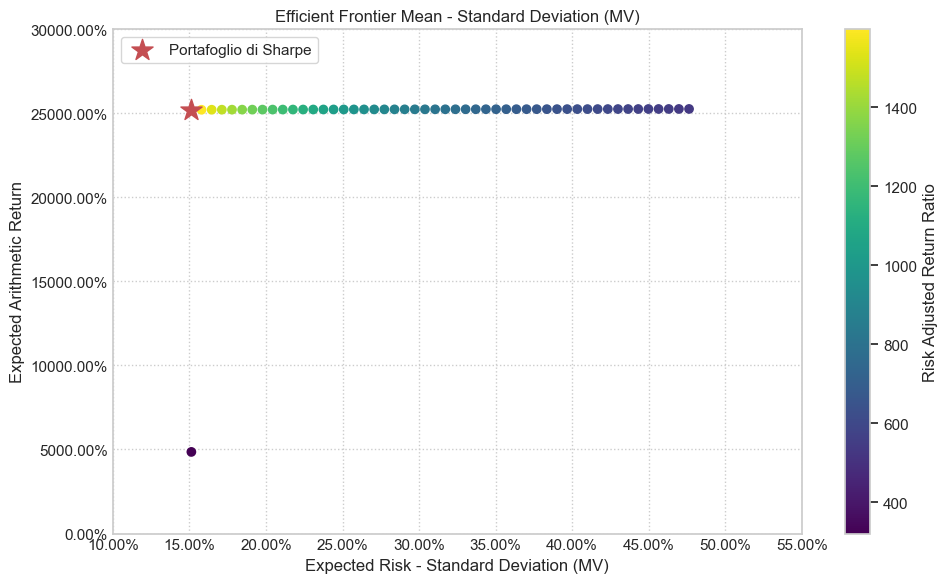

In [ ]:
label = 'Portafoglio di Sharpe'
mu = port.mu
cov = port.cov
returns = port.returns

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [ ]:
portfolio_returns = pd.DataFrame(np.dot(port.returns.ffill(), w).cumsum())
benchmark_returns = benchmark_returns.ffill() # Gestione dei valori mancanti
covariance_matrix = np.cov(portfolio_returns.squeeze(), benchmark_returns.squeeze())
portfolio_beta = covariance_matrix[0, 1] / np.var(benchmark_returns)
print("Beta del Portafoglio:", portfolio_beta)

NameError: name 'benchmark_returns' is not defined

In [ ]:
equal_weights = pd.DataFrame(np.array([1/len(tickers)] *  len(tickers)), columns=["weight"], index=tickers)
weights.T

NameError: name 'weights' is not defined

In [ ]:
ax = rp.plot_pie(w=weights, title='Portafoglio Effettivo', nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)


In [ ]:
cov_matrix = net_returns.cov()
portfolio_variance = np.dot(weights.T, np.dot(cov_matrix, weights))
print("Volatilità del Portafoglio Effettivo:",np.sqrt(portfolio_variance))

In [ ]:
portfolio_returns = np.dot(net_returns, weights).cumsum()
plt.figure(figsize=(10, 6))
plt.plot(net_returns.index, portfolio_returns, label='Portfolio Returns', color='blue')
plt.xlabel('Data')
plt.ylabel('Rendimento del portafoglio')
plt.title('Rendimento del Portafoglio')
plt.legend()
plt.show()

In [ ]:
print(f"Il rendimento del Portafoglio Effettivo:",{portfolio_returns[-1]*100},'%')